**Автор: Анна Смелова**

## Курсовая работа по курсу "Библиотеки Python для Data Science: продолжение"

**Материалы к проекту (файлы):**
course_project_train.csv, 
course_project_test.csv

**Задание:**
Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Целевая переменная:**
Credit Default - факт невыполнения кредитных обязательств

**Метрика качества:**
F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения, которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение 
* **Annual Income** - годовой доход 
* **Years in current job** - количество лет на текущем месте работы 
* **Tax Liens** - налоговые обременения 
* **Number of Open Accounts** - количество открытых счетов 
* **Years of Credit History** - количество лет кредитной истории 
* **Maximum Open Credit** - наибольший открытый кредит 
* **Number of Credit Problems** - количество проблем с кредитом 
* **Months since last delinquent** - количество месяцев с последней просрочки платежа 
* **Bankruptcies** - банкротства 
* **Purpose** - цель кредита 
* **Term** - срок кредита 
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс 
* **Monthly Debt** - ежемесячный долг 
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка) 

**Пути к директориям и файлам**

In [1]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

## Шаг 1: Подготовка инструментов

### 1.1 Необходимые модули

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from imblearn import over_sampling, under_sampling
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, StratifiedKFold
from sklearn.metrics import f1_score, r2_score, precision_score, recall_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.preprocessing import StandardScaler
from xverse.transformer import WOE

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### 1.2 Загрузка данных

Загрузим тренировочные данные в переменную **train_data**, тестовые данные в переменную **test_data**

In [3]:
train_data_base=pd.read_csv(TRAIN_DATASET_PATH)
train_data=train_data_base.copy()
train_data.shape

(7500, 17)

In [4]:
test_data_base=pd.read_csv(TEST_DATASET_PATH)
test_data=test_data_base.copy()
test_data.shape

(2500, 16)

### 1.3 Необходимые функции

In [5]:
def missing_percentage(df):
    total = df.isnull().sum().sort_values(ascending=False)[df.isnull().sum().sort_values(ascending=False)!=0]
    percent = (df.isnull().sum().sort_values(
        ascending=False)/len(df)*100)[df.isnull().sum().sort_values(ascending=False)/len(df)*100!=0]
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [6]:
def evaluate_preds(model, y_train, y_test, train_pool, test_pool):
    y_train_pred = model.predict(train_pool)
    y_test_pred = model.predict(test_pool)
    
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [7]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [8]:
def show_train_test_displot_and_boxplot(feature, train, test, title, figsize):
    train_target_mean = round(train[feature].mean(), 2)
    train_target_median = train[feature].median()
    train_target_mode = train[feature].mode()[0]
    
    test_target_mean = round(test[feature].mean(), 2)
    test_target_median = test[feature].median()
    test_target_mode = test[feature].mode()[0]
    
    fig = plt.figure(figsize = figsize)
    
    fig.add_subplot(1,2,1)
    sns.distplot(train[feature], bins=70, color='green', label='Train')
    sns.distplot(test[feature], bins=70, color='yellow', label='Test')
    
    plt.axvline(x=[train_target_mean], label=f'train_target_mean={train_target_mean}', linestyle=':',
                linewidth=4, color='red')
    plt.axvline(x=[test_target_mean], label=f'test_target_mean={test_target_mean}', linestyle=':',
                linewidth=4, color='DarkRed')
    
    plt.axvline(x=[train_target_median], label=f'train_target_median={train_target_median}', linestyle='--', 
                linewidth=4, color='coral')
    plt.axvline(x=[test_target_median], label=f'test_target_median={test_target_median}', linestyle='--', 
                linewidth=4, color='violet')
    
    plt.axvline(x=[train_target_mode], label=f'train_target_mode={train_target_mode}', linestyle='-.', 
                linewidth=4, color='blue')
    plt.axvline(x=[test_target_mode], label=f'test_target_mode={test_target_mode}', linestyle='-.', 
                linewidth=4, color='DarkBlue')
    plt.legend()
    
    fig.add_subplot(1,2,2)
    my_pal = {'Train': 'LightGreen', 'Test': 'LightYellow'}
    df = pd.DataFrame({'Train' : train[feature].dropna(), 'Test' : test[feature].dropna()})
    sns.boxplot(x='value', y='variable', data=pd.melt(df), palette=my_pal)
    
    plt.tight_layout()
    plt.title(title)

In [9]:
def feature_grouped_by_target(feature_name, data, figsize, condition=True):
    
    target_name = 'Credit Default'
    feature_with_target = data[[feature_name, target_name]]
    feature = feature_with_target[feature_name]
    feature_target_0 = feature[(feature_with_target[target_name] == 0) & (condition)]
    feature_target_1 = feature[(feature_with_target[target_name] == 1) & (condition)]
    
    fig = plt.figure(figsize = figsize)
    
    fig.add_subplot(1,2,1)

    sns.kdeplot(feature_target_0, shade=True, label='Нет просрочки', color='g')
    sns.kdeplot(feature_target_1, shade=True, label='Просрочка', color='r')

    plt.xlabel(feature_name)
    plt.title(f'{feature_name} grouped by target variable')
    
    fig.add_subplot(1,2,2)
    
    sns.pointplot(x=target_name, y=feature_name, data=feature_with_target, capsize=.1)
    plt.title(f'Confidence intervals (95 %) for {feature_name}')

## Шаг 2: Подготовка данных

In [10]:
train_data.head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0


In [11]:
test_data.head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0


### 2.1 Обработка пропущенных значений

#### 2.1.1 Анализ пропущенных значений

In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

,Months since last delinquent,Annual Income,Credit Score,Years in current job,Bankruptcies
Total,4081,1557,1557,371,14
Percent,54.4133,20.76,20.76,4.94667,0.186667


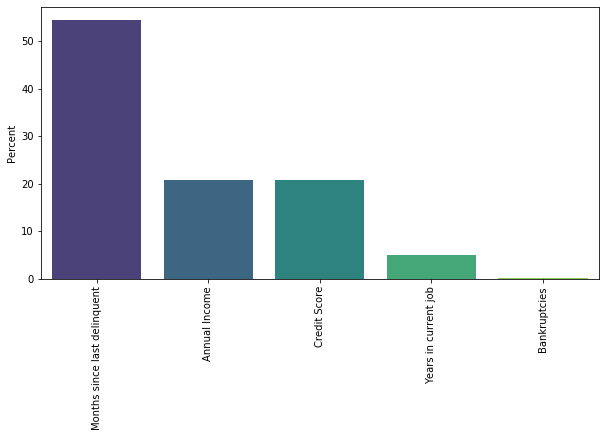

In [13]:
missing = missing_percentage(train_data)
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=missing.index, y='Percent', data=missing, palette='viridis')
plt.xticks(rotation=90)
display(missing.T.style.background_gradient(cmap='viridis_r', axis=1))

In [14]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
Home Ownership                  2500 non-null object
Annual Income                   1987 non-null float64
Years in current job            2414 non-null object
Tax Liens                       2500 non-null float64
Number of Open Accounts         2500 non-null float64
Years of Credit History         2500 non-null float64
Maximum Open Credit             2500 non-null float64
Number of Credit Problems       2500 non-null float64
Months since last delinquent    1142 non-null float64
Bankruptcies                    2497 non-null float64
Purpose                         2500 non-null object
Term                            2500 non-null object
Current Loan Amount             2500 non-null float64
Current Credit Balance          2500 non-null float64
Monthly Debt                    2500 non-null float64
Credit Score                    1987 non-null float64
dtypes: float64(12), object(4)
me

,Months since last delinquent,Credit Score,Annual Income,Years in current job,Bankruptcies
Total,1358,513,513,86,3
Percent,54.32,20.52,20.52,3.44,0.12


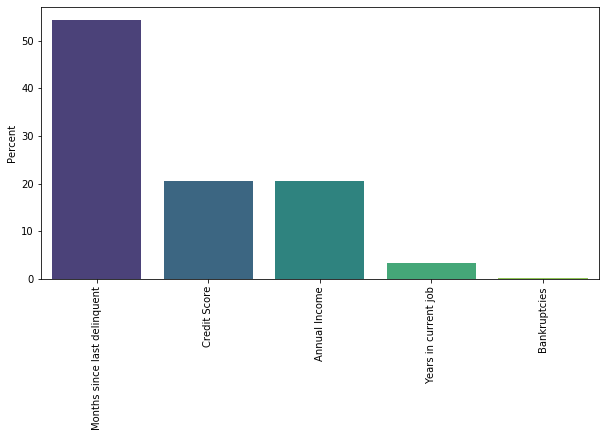

In [15]:
missing = missing_percentage(test_data)
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=missing.index, y='Percent', data=missing, palette='viridis')
plt.xticks(rotation=90)
display(missing.T.style.background_gradient(cmap='viridis_r', axis=1))

"Annual Income" и "Credit Score" имеют одинаковое количество пропусков. И данные пропуски относятся к одинаковым объектам. 

In [16]:
display(train_data.loc[(train_data['Annual Income'].isnull()) & (train_data['Credit Score'].isnull())].shape,
       test_data.loc[(test_data['Annual Income'].isnull()) & (test_data['Credit Score'].isnull())].shape)

(1557, 17)

(513, 16)

#### 2.1.2 Обработка пропущенных значений для Annual Income и Credit Score
Annual Income и Credit Score заполним медианным значением в группировке по Number of Credit Problems.

In [17]:
# Добавим категориальные признаки отображающие объекты, где были пропуски.
train_data['Null Annual Income and Credit Score'] = (train_data['Annual Income'].isnull()).astype('int64')
test_data['Null Annual Income and Credit Score'] = (test_data['Annual Income'].isnull()).astype('int64')

In [18]:
# Обработаем выбросы 'Credit Score' тут, чтобы не испортить средние значения
train_data.loc[train_data['Credit Score']>=4000,'Credit Score'] = train_data.loc[train_data['Credit Score']>=4000,'Credit Score'] / 10
test_data.loc[test_data['Credit Score']>=4000,'Credit Score'] = test_data.loc[test_data['Credit Score']>=4000,'Credit Score'] / 10

In [19]:
# Средние будем вычислять по суммарным данным (трейн+тест).
features = ['Annual Income','Credit Score','Number of Credit Problems']
full_data = pd.concat([train_data[features], test_data[features]]).reset_index(drop=True)
print(full_data.shape)

(10000, 3)


In [20]:
full_data['Annual Income_median'] = full_data.groupby('Number of Credit Problems')['Annual Income'].transform('median')
full_data['Credit Score_median'] = full_data.groupby('Number of Credit Problems')['Credit Score'].transform('median')
full_data = full_data.drop(['Annual Income','Credit Score'],axis=1)
full_data = full_data.drop_duplicates()
full_data

,Number of Credit Problems,Annual Income_median,Credit Score_median
0,1.0,1091702.0,724.0
1,0.0,1194967.0,729.0
39,3.0,985815.0,727.0
112,2.0,1213036.0,719.0
1129,6.0,2117246.0,725.5
1860,4.0,1451087.0,713.0
3028,5.0,1268896.0,703.0
5969,7.0,2029200.0,710.5
9782,15.0,1410294.0,746.0


In [21]:
train_data = pd.merge(train_data,full_data)
train_data.loc[~train_data['Annual Income'].isnull(), 'Annual Income_median'] = train_data.loc[~train_data['Annual Income'].isnull(), 'Annual Income']
train_data.loc[~train_data['Credit Score'].isnull(), 'Credit Score_median'] = train_data.loc[~train_data['Credit Score'].isnull(), 'Credit Score']

test_data = pd.merge(test_data,full_data)
test_data.loc[~test_data['Annual Income'].isnull(), 'Annual Income_median'] = test_data.loc[~test_data['Annual Income'].isnull(), 'Annual Income']
test_data.loc[~test_data['Credit Score'].isnull(), 'Credit Score_median'] = test_data.loc[~test_data['Credit Score'].isnull(), 'Credit Score']

train_data['Annual Income'] = train_data['Annual Income_median']
train_data['Credit Score'] = train_data['Credit Score_median']
train_data = train_data.drop(['Annual Income_median','Credit Score_median'],axis=1)

test_data['Annual Income'] = test_data['Annual Income_median']
test_data['Credit Score'] = test_data['Credit Score_median']
test_data = test_data.drop(['Annual Income_median','Credit Score_median'],axis=1)

#### 2.1.3 Обработка пропущенных значений для Months since last delinquent
Months since last delinquent - пропусков более 50%. Несмотря на это, удалять признак не будем, логично будет предположить, что там, где значения не указаны, просрочек вообще не было. Заменим пропущенные значения на 1000.

In [22]:
train_data.loc[train_data['Months since last delinquent'].isnull(),'Months since last delinquent'] = 1000
test_data.loc[test_data['Months since last delinquent'].isnull(),'Months since last delinquent'] = 1000

#### 2.1.4 Обработка пропущенных значений для Bankruptcies
Bankruptcies заполним 0, если при этом не указано количество месяцев с последней просрочки платежа(Months since last delinquent), считая, что раз не указано, значит их и не было. Если указано, то заполним 1.

In [23]:
train_data.loc[(train_data['Bankruptcies'].isnull()) & (train_data['Months since last delinquent']==1000), 'Bankruptcies'] = 0
train_data.loc[(train_data['Bankruptcies'].isnull()) & (train_data['Months since last delinquent']!=1000), 'Bankruptcies'] = 1

test_data.loc[(test_data['Bankruptcies'].isnull()) & (test_data['Months since last delinquent']==1000), 'Bankruptcies'] = 0
test_data.loc[(test_data['Bankruptcies'].isnull()) & (test_data['Months since last delinquent']!=1000), 'Bankruptcies'] = 1

#### 2.1.5 Обработка пропущенных значений для Years in current job
Years in current job - заменим категориальные значения на количественные и заполним пропуски значением 0(считаем таких безработными).

In [24]:
map_Years_in_current_job = {
    '< 1 year': 0.5,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}

train_data['Years in current job'] = train_data['Years in current job'].map(map_Years_in_current_job)
test_data['Years in current job'] = test_data['Years in current job'].map(map_Years_in_current_job)
train_data.loc[train_data['Years in current job'].isnull(), 'Years in current job'] = 0
test_data.loc[test_data['Years in current job'].isnull(), 'Years in current job'] = 0

### 2.2 Приведение типов данных

Признаки 'Home Ownership', 'Purpose', 'Term' и 'Null Annual Income and Credit Score' являются категориальными или ранговыми, приведем их к типу 'object'.<br>
Затем разделим данные на количественные и категориальные.

In [25]:
for colname in ['Home Ownership', 'Purpose', 'Term', 'Null Annual Income and Credit Score']:
    train_data[colname] = train_data[colname].astype(str)
    test_data[colname] = test_data[colname].astype(str)

In [26]:
target_feature = 'Credit Default'
base_features = train_data.drop(['Credit Default'], axis=1).columns.tolist()
num_features = train_data.select_dtypes(exclude=['object']).drop(['Credit Default'], axis=1).columns
cat_features = train_data.select_dtypes(include=['object']).columns

display(len(base_features), base_features, len(num_features), num_features, len(cat_features), cat_features)

17

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Null Annual Income and Credit Score']

13

Index(['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount',
       'Current Credit Balance', 'Monthly Debt', 'Credit Score'],
      dtype='object')

4

Index(['Home Ownership', 'Purpose', 'Term',
       'Null Annual Income and Credit Score'],
      dtype='object')

### 2.3 Анализ признаков

In [27]:
bad_features = []

#### 2.3.1 Annual Income - годовой доход

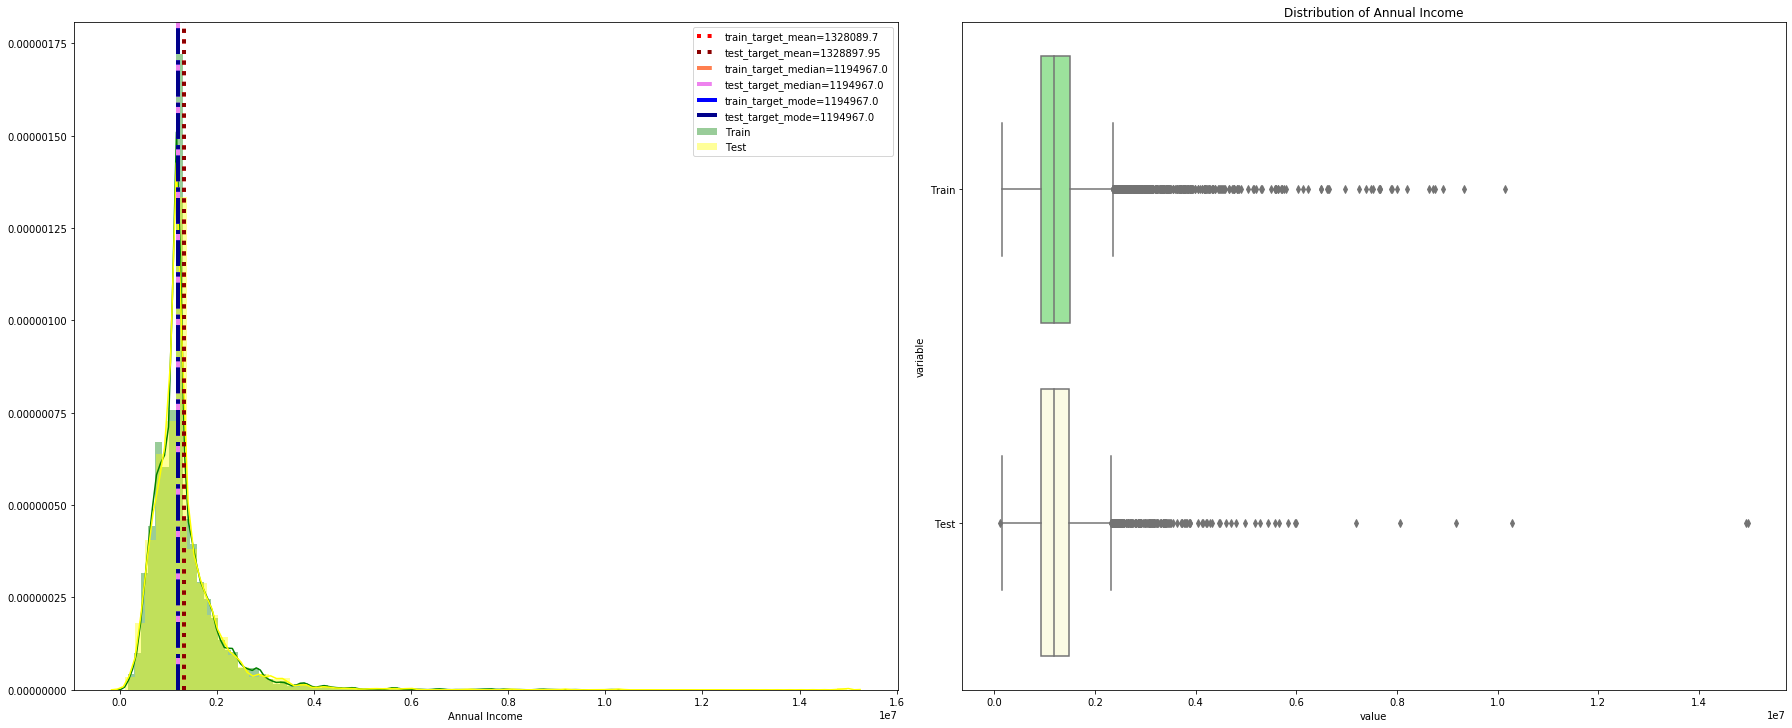

In [28]:
show_train_test_displot_and_boxplot(feature='Annual Income', train=train_data, test=test_data, 
                        title='Distribution of Annual Income', figsize=(25,10))

Распределения и средние значения на трейне и на тесте в целом совпадают. 
С выбросами пока ничего делать не будем, непонятно, ошибка ли это в данных или нет.

In [29]:
train_data[train_data['Annual Income']>1e7]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Null Annual Income and Credit Score
6462,Rent,10149344.0,5.0,0.0,10.0,17.5,270380.0,0.0,22.0,0.0,debt consolidation,Short Term,664818.0,205713.0,61235.0,692.0,0,0


In [30]:
test_data[test_data['Annual Income']>1e7]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Null Annual Income and Credit Score
33,Home Mortgage,14934114.0,7.0,0.0,7.0,15.4,177298.0,0.0,1000.0,0.0,other,Short Term,99770.0,57722.0,7218.0,746.0,0
174,Rent,14975610.0,5.0,0.0,5.0,44.3,155518.0,0.0,1000.0,0.0,major purchase,Long Term,133386.0,103968.0,3369.0,738.0,0
970,Home Mortgage,10275770.0,6.0,0.0,18.0,15.6,1242538.0,0.0,1000.0,0.0,debt consolidation,Long Term,608432.0,115900.0,79038.0,746.0,0


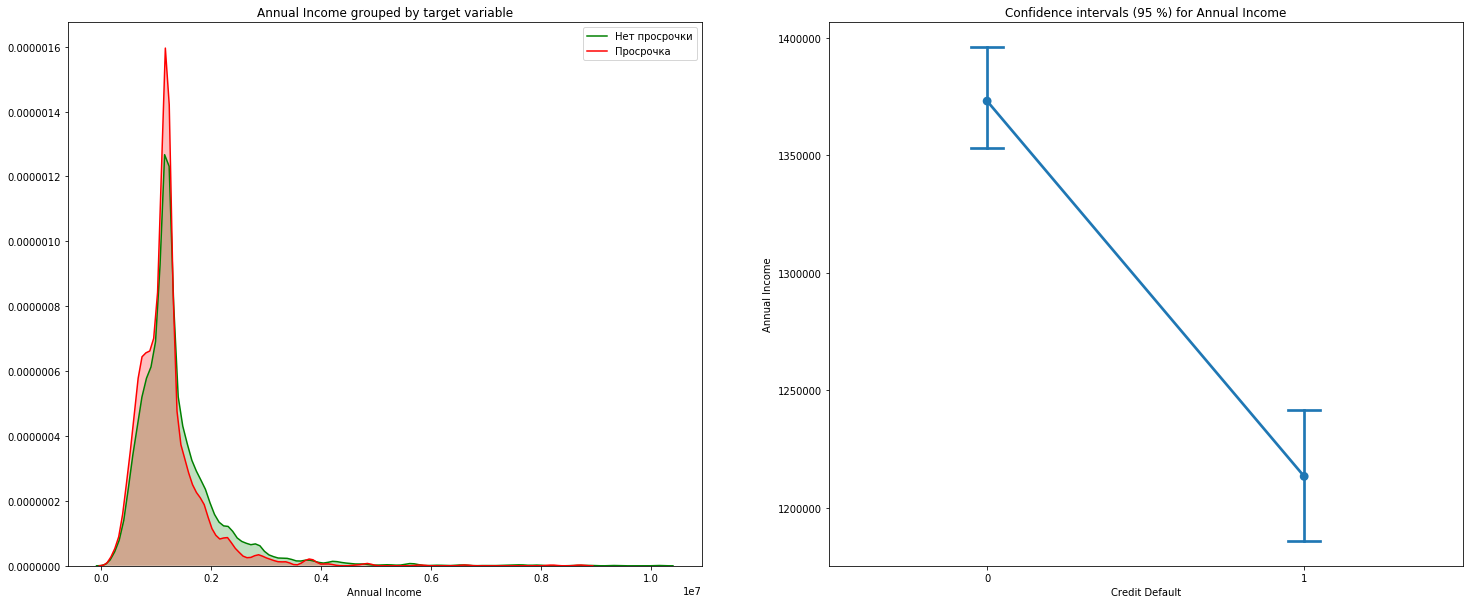

In [31]:
feature_grouped_by_target('Annual Income', train_data, figsize=(25,10), condition=True)

#### 2.3.2 Tax Liens - налоговые обременения 

In [32]:
test_data.loc[test_data['Tax Liens']>8, 'Tax Liens'] = train_data['Tax Liens'].max()

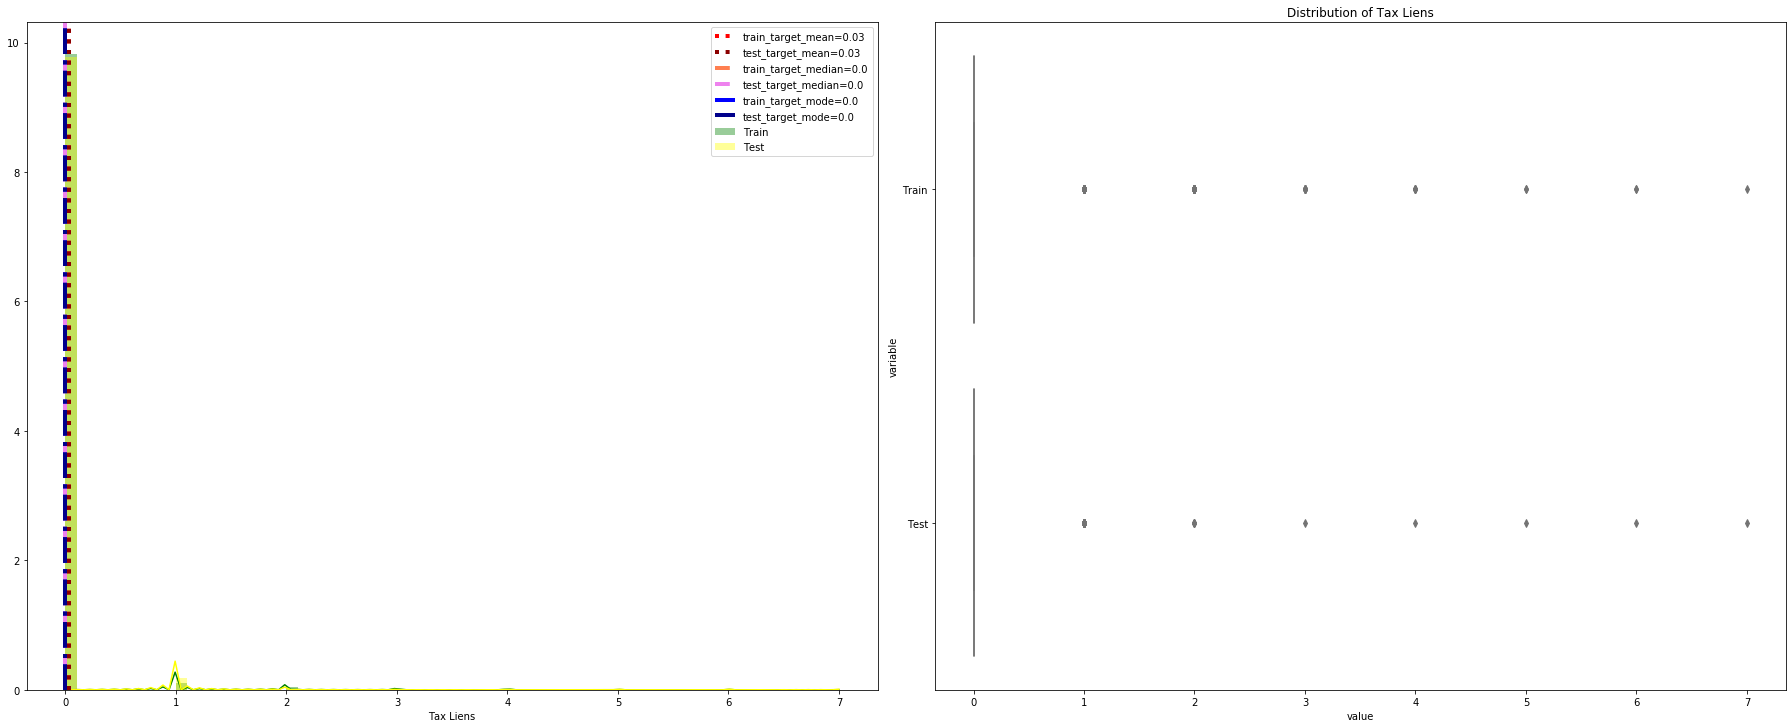

In [33]:
show_train_test_displot_and_boxplot(feature='Tax Liens', train=train_data, test=test_data, 
                        title='Distribution of Tax Liens', figsize=(25,10))

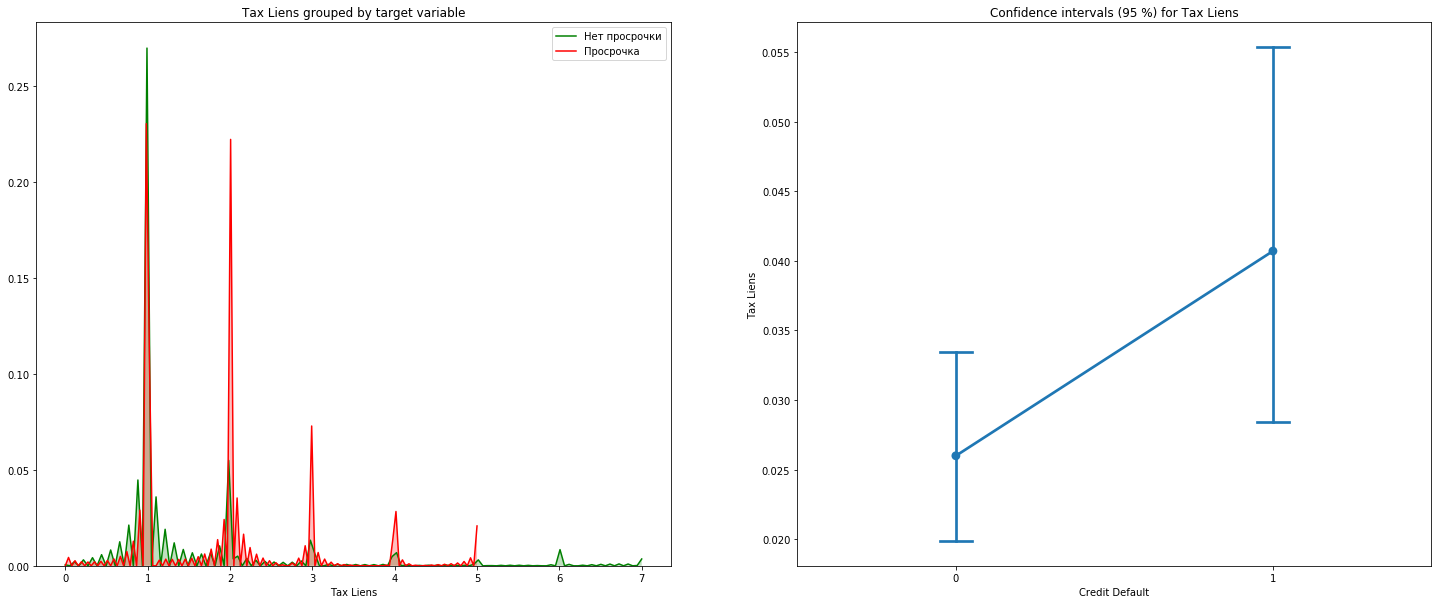

In [34]:
feature_grouped_by_target('Tax Liens', train_data, figsize=(25,10), condition=True)

In [35]:
# Потенциально бесполезный признак
bad_features.append('Tax Liens')

#### 2.3.3 Number of Open Accounts - количество открытых счетов

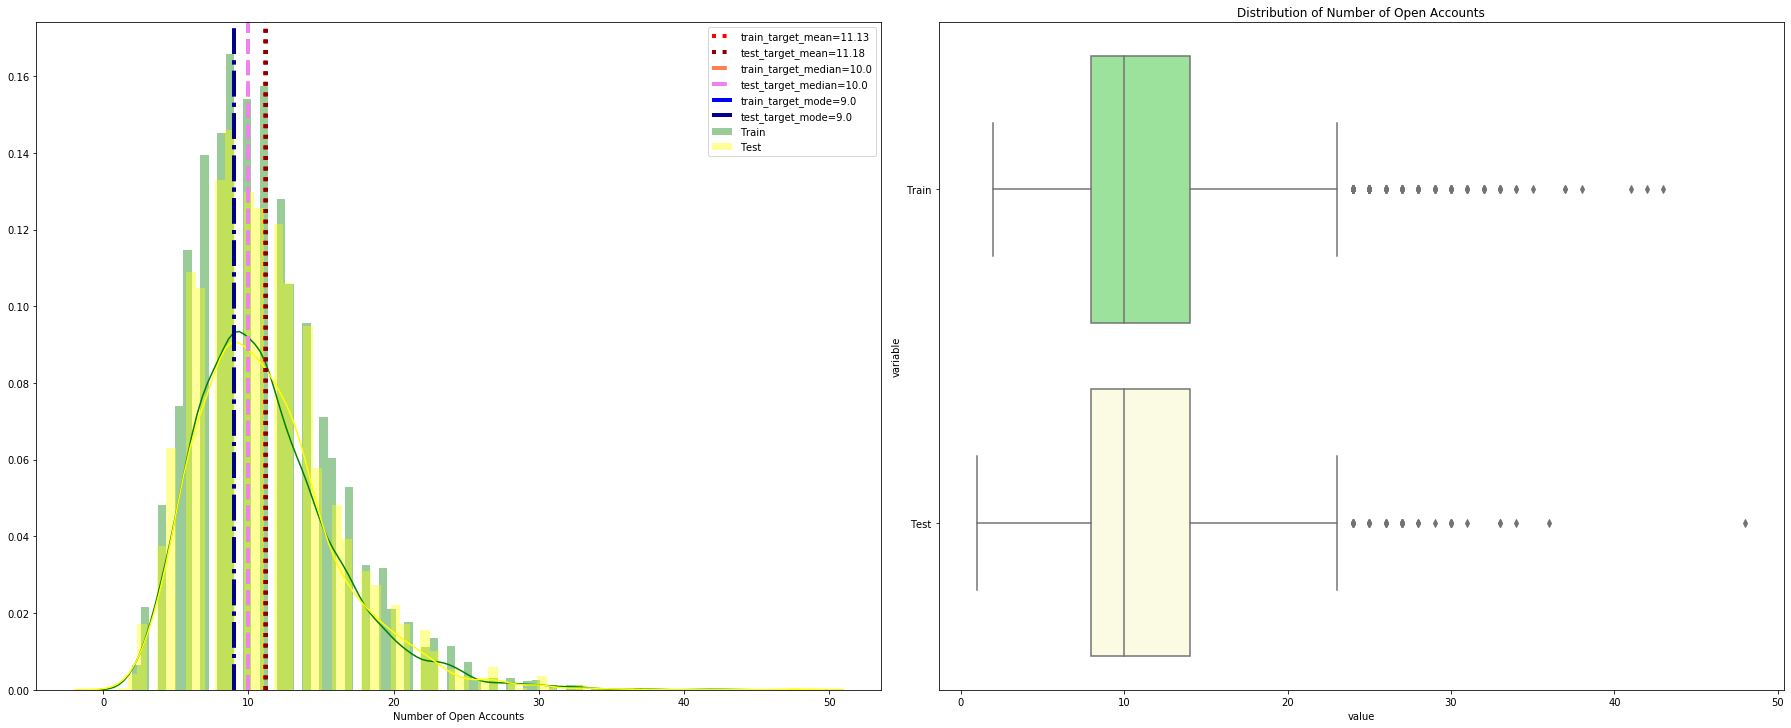

In [36]:
show_train_test_displot_and_boxplot(feature='Number of Open Accounts', train=train_data, test=test_data, 
                        title='Distribution of Number of Open Accounts', figsize=(25,10))

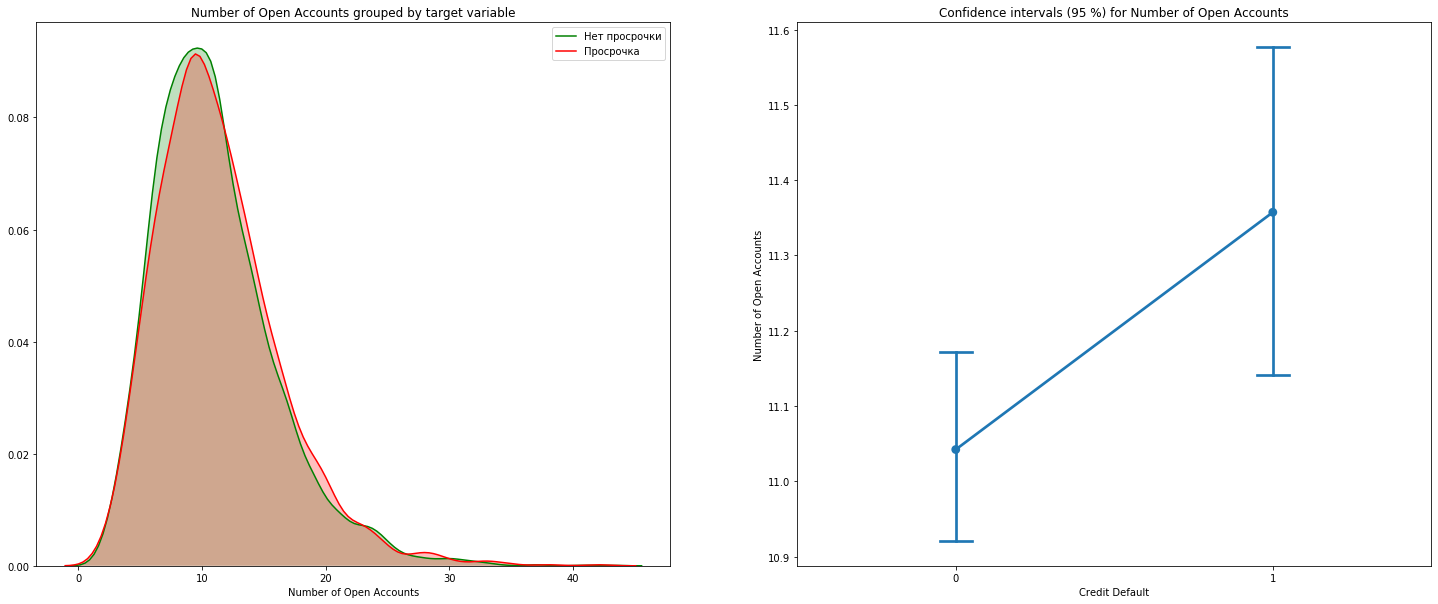

In [37]:
feature_grouped_by_target('Number of Open Accounts', train_data, figsize=(25,10), condition=True)

In [38]:
display(train_data[train_data['Number of Open Accounts']>40], test_data[test_data['Number of Open Accounts']>40])

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Null Annual Income and Credit Score
2427,Home Mortgage,2915759.0,2.0,0.0,43.0,29.0,1729882.0,0.0,1000.0,0.0,home improvements,Long Term,715484.0,448191.0,40578.0,672.0,0,0
3354,Rent,2714264.0,10.0,0.0,41.0,21.2,1397352.0,0.0,1000.0,0.0,debt consolidation,Short Term,448976.0,637184.0,43880.0,720.0,0,0
5820,Rent,2167178.0,8.0,0.0,42.0,27.5,1913538.0,0.0,1000.0,0.0,debt consolidation,Short Term,777238.0,1388178.0,62487.0,680.0,1,0


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Null Annual Income and Credit Score
2175,Home Mortgage,1171806.0,2.0,0.0,48.0,12.8,1706430.0,0.0,1000.0,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0,0


In [39]:
# Потенциально бесполезный признак
#bad_features.append('Number of Open Accounts')

#### 2.3.4 Years of Credit History - количество лет кредитной истории

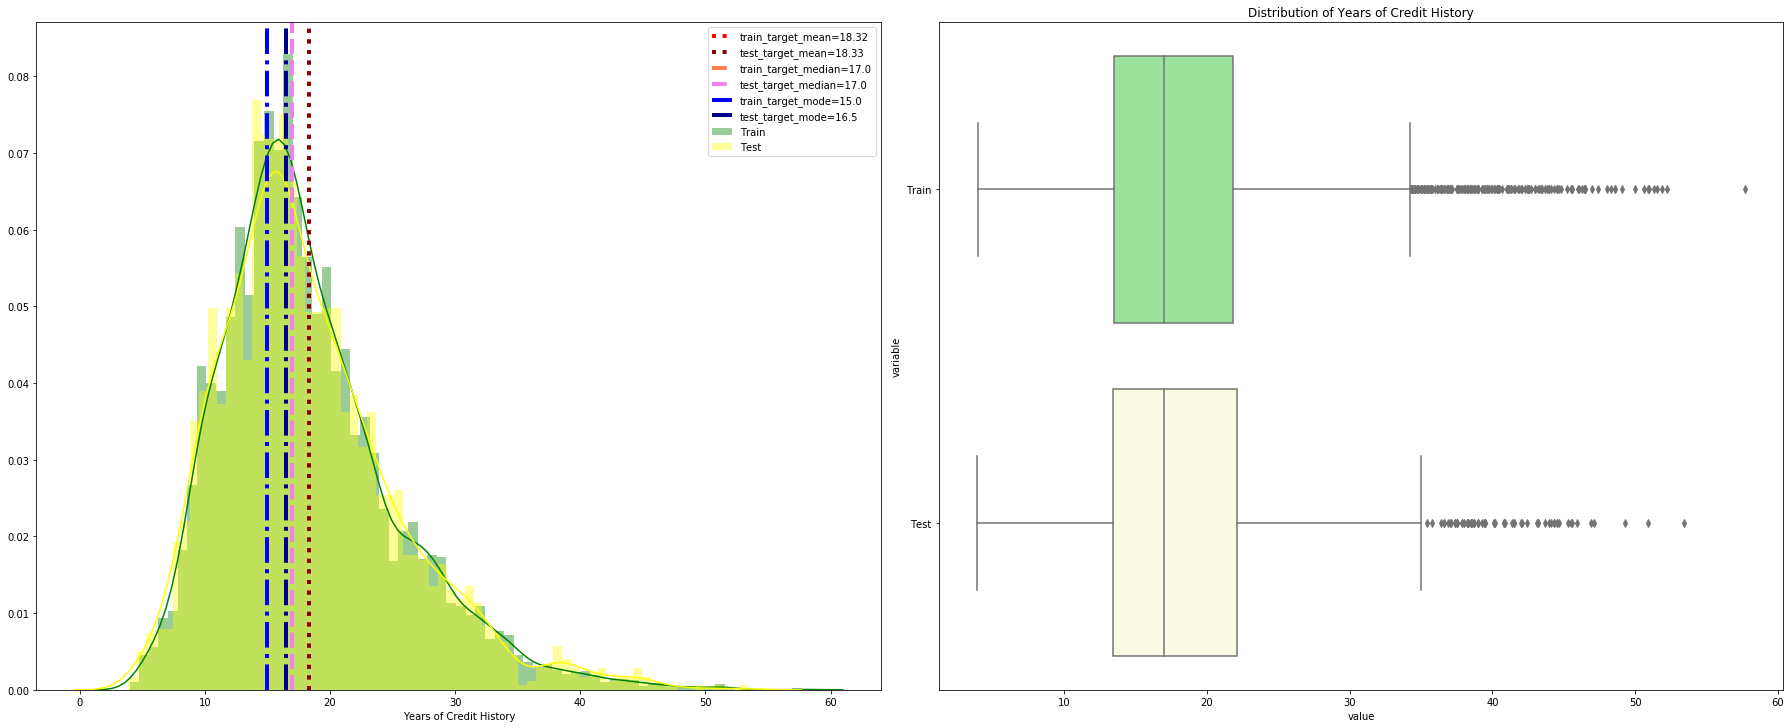

In [40]:
show_train_test_displot_and_boxplot(feature='Years of Credit History', train=train_data, test=test_data, 
                        title='Distribution of Years of Credit History', figsize=(25,10))

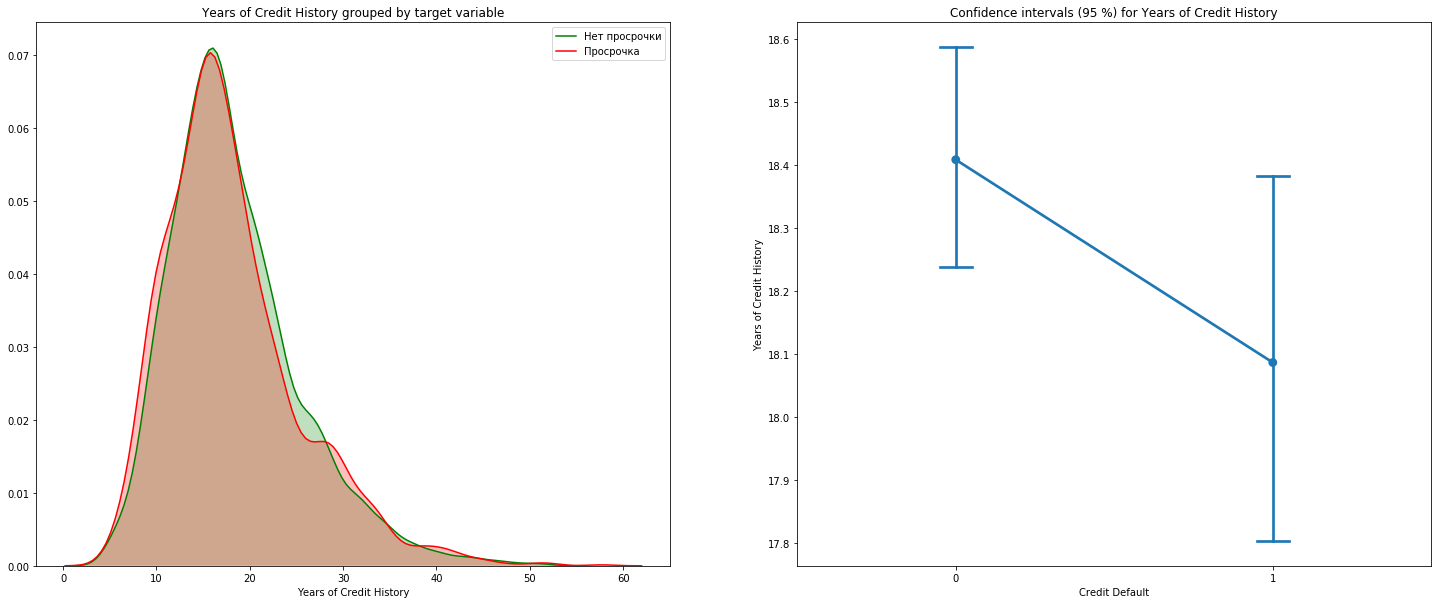

In [41]:
feature_grouped_by_target('Years of Credit History', train_data, figsize=(25,10), condition=True)

In [42]:
# Потенциально бесполезный признак
#bad_features.append('Years of Credit History')

#### 2.3.5 Maximum Open Credit - наибольший открытый кредит

In [43]:
train_data.loc[train_data['Maximum Open Credit']>1e7, 'Maximum Open Credit']=train_data.loc[train_data['Maximum Open Credit']<1e7, 'Maximum Open Credit'].max()
test_data.loc[test_data['Maximum Open Credit']>1e7, 'Maximum Open Credit']=train_data.loc[train_data['Maximum Open Credit']<1e7, 'Maximum Open Credit'].max()

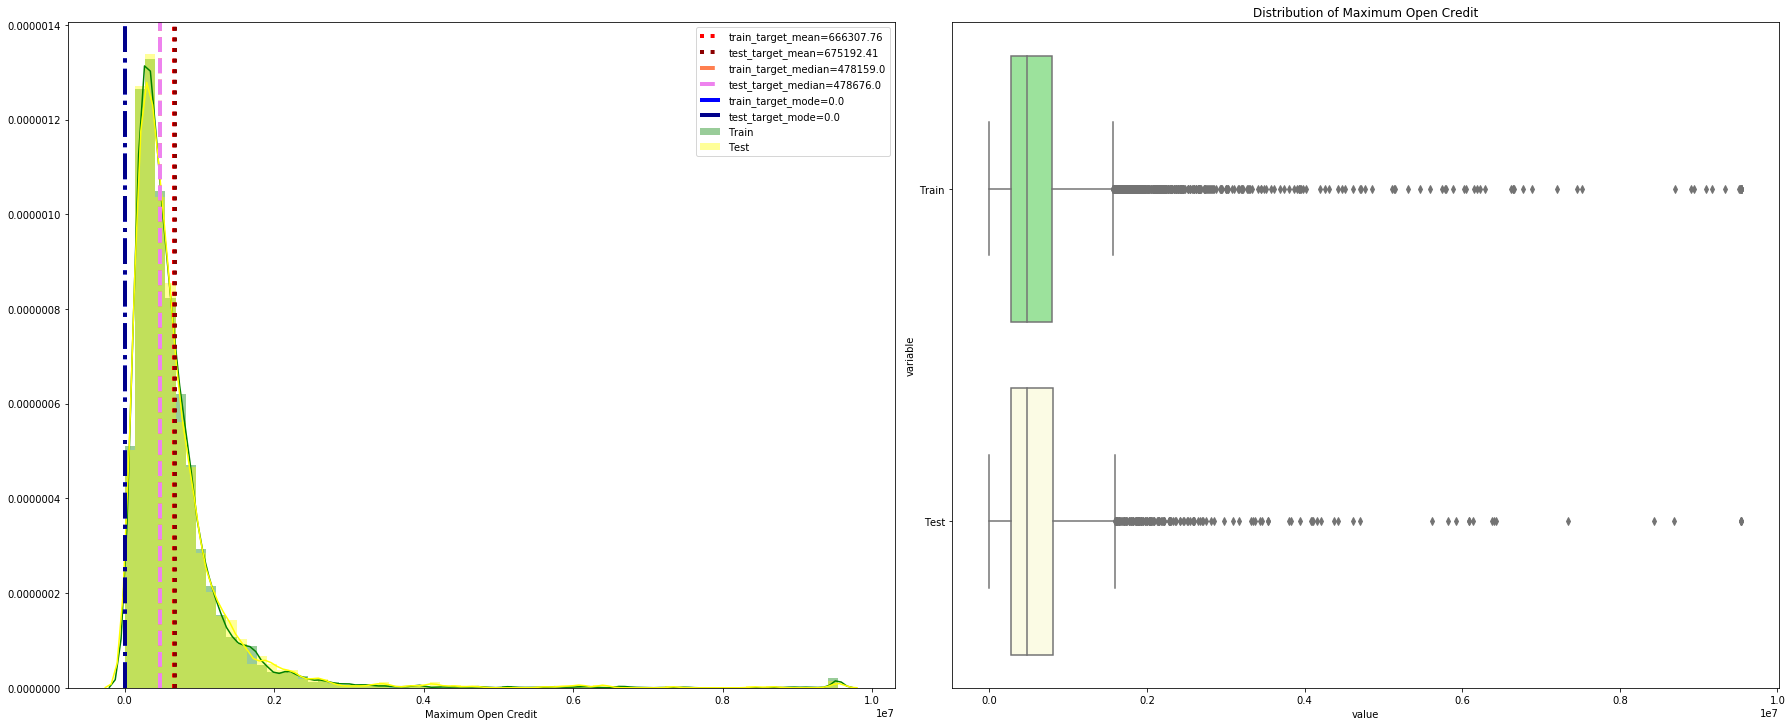

In [44]:
show_train_test_displot_and_boxplot(feature='Maximum Open Credit', train=train_data, test=test_data, 
                        title='Distribution of Maximum Open Credit', figsize=(25,10))

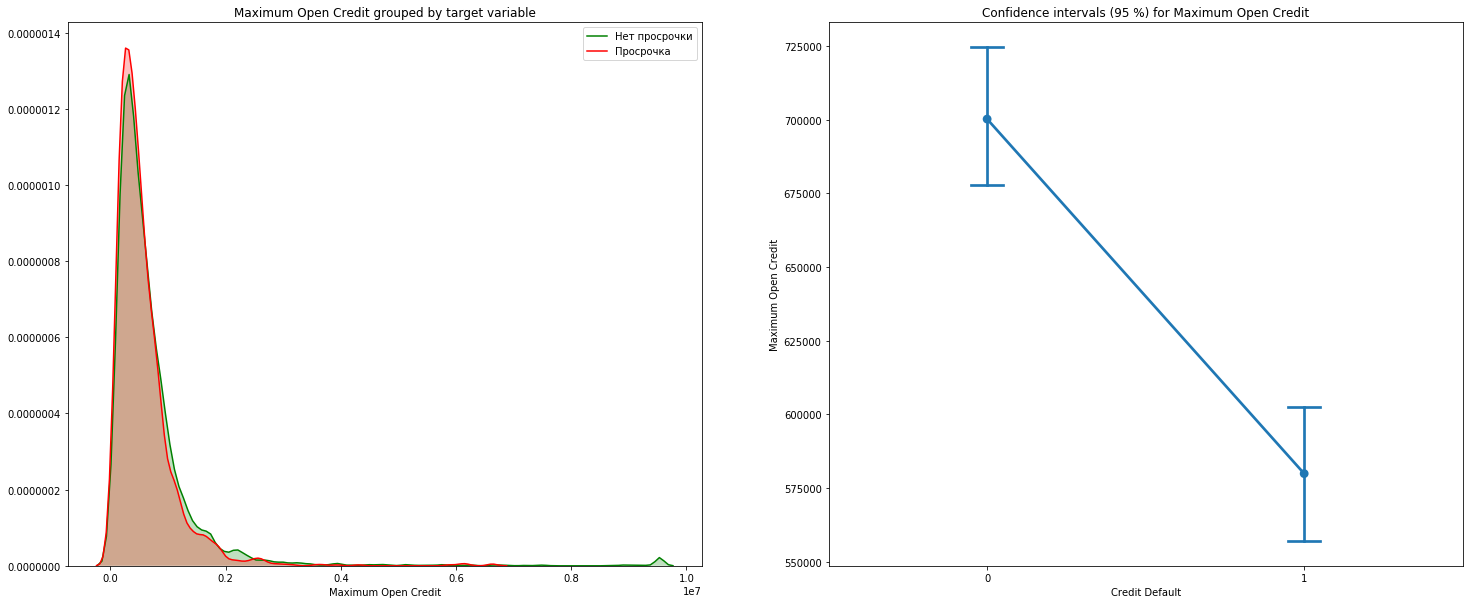

In [45]:
feature_grouped_by_target('Maximum Open Credit', train_data, figsize=(25,10), condition=True)

#### 2.3.6 Number of Credit Problems - количество проблем с кредитом

In [46]:
train_data.loc[train_data['Number of Credit Problems']>4, 'Number of Credit Problems'] = 4
test_data.loc[test_data['Number of Credit Problems']>4, 'Number of Credit Problems'] = 4

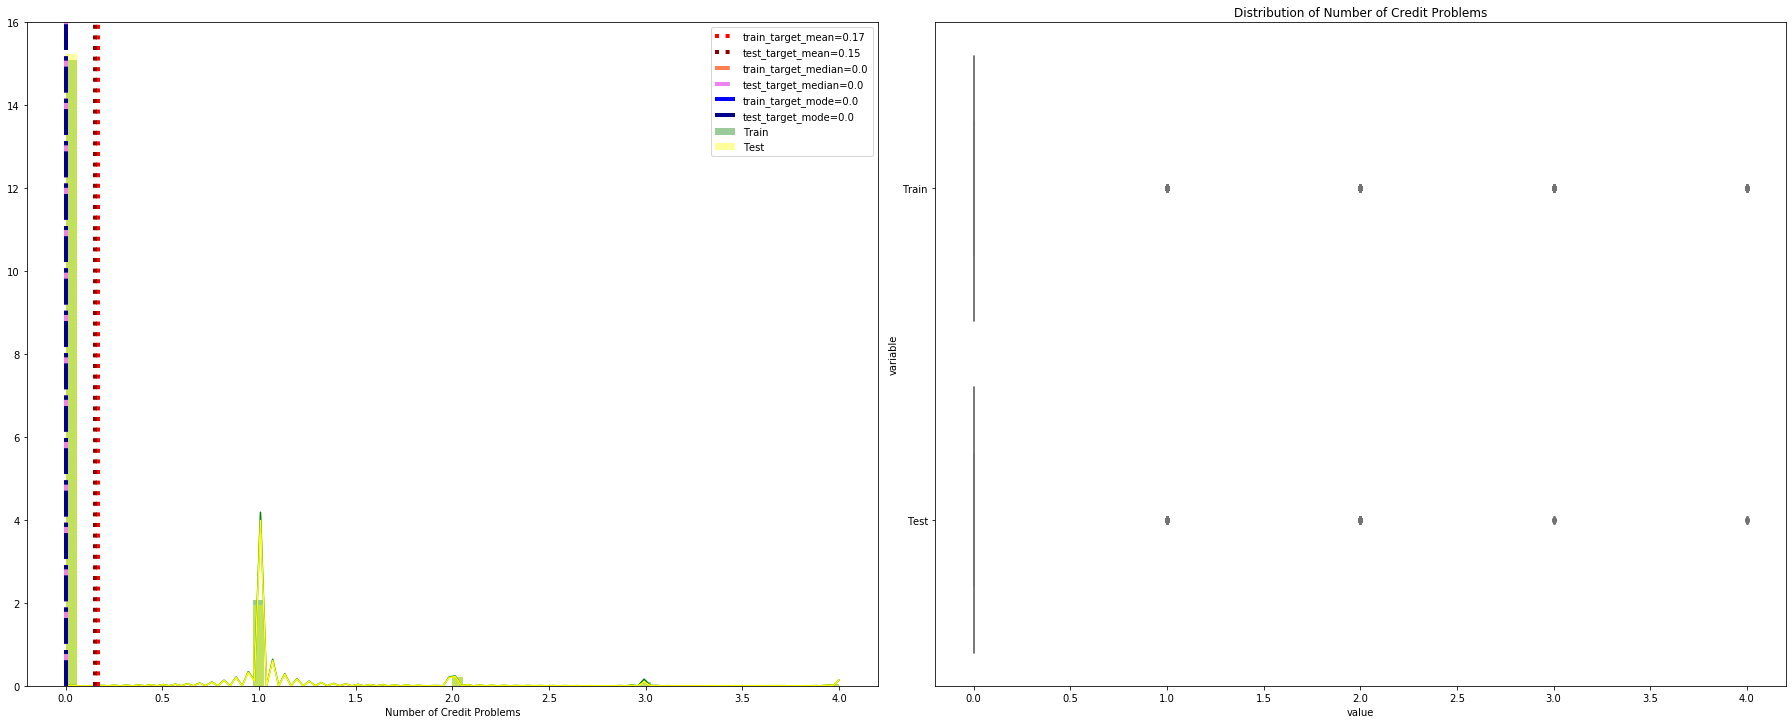

In [47]:
show_train_test_displot_and_boxplot(feature='Number of Credit Problems', train=train_data, test=test_data, 
                        title='Distribution of Number of Credit Problems', figsize=(25,10))

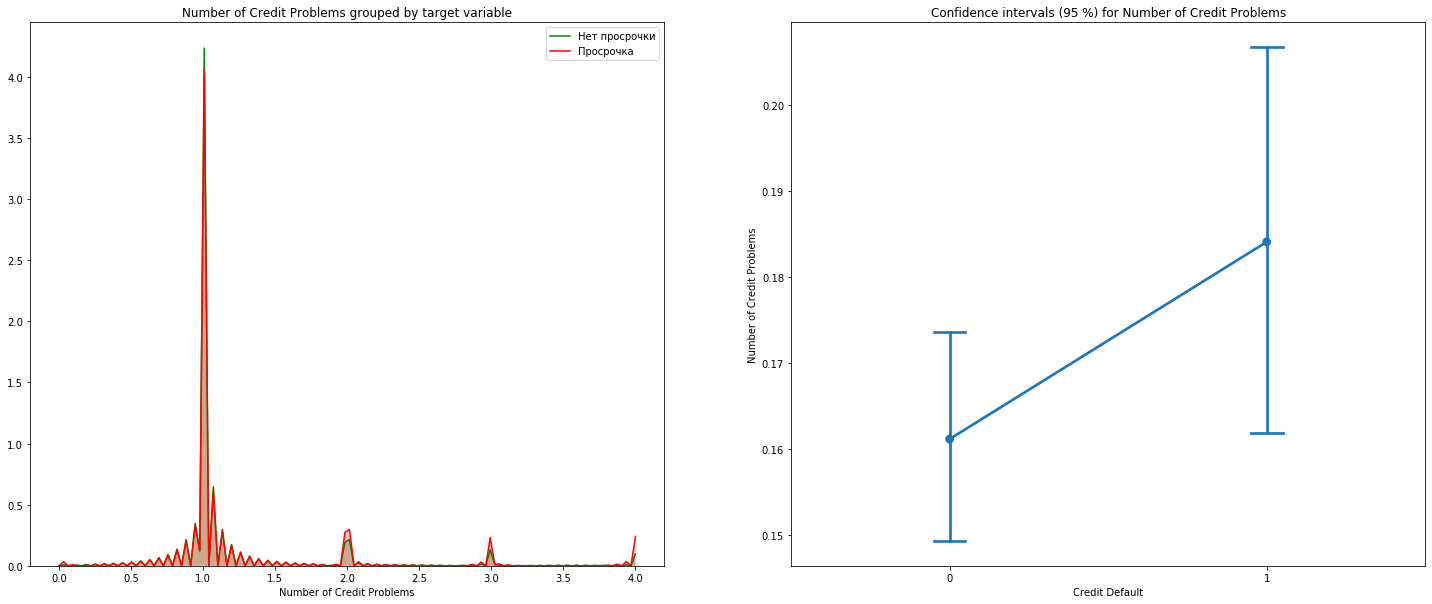

In [48]:
feature_grouped_by_target('Number of Credit Problems', train_data, figsize=(25,10), condition=True)

In [49]:
# Потенциально бесполезный признак
bad_features.append('Number of Credit Problems')

#### 2.3.7 Months since last delinquent - количество месяцев с последней просрочки платежа

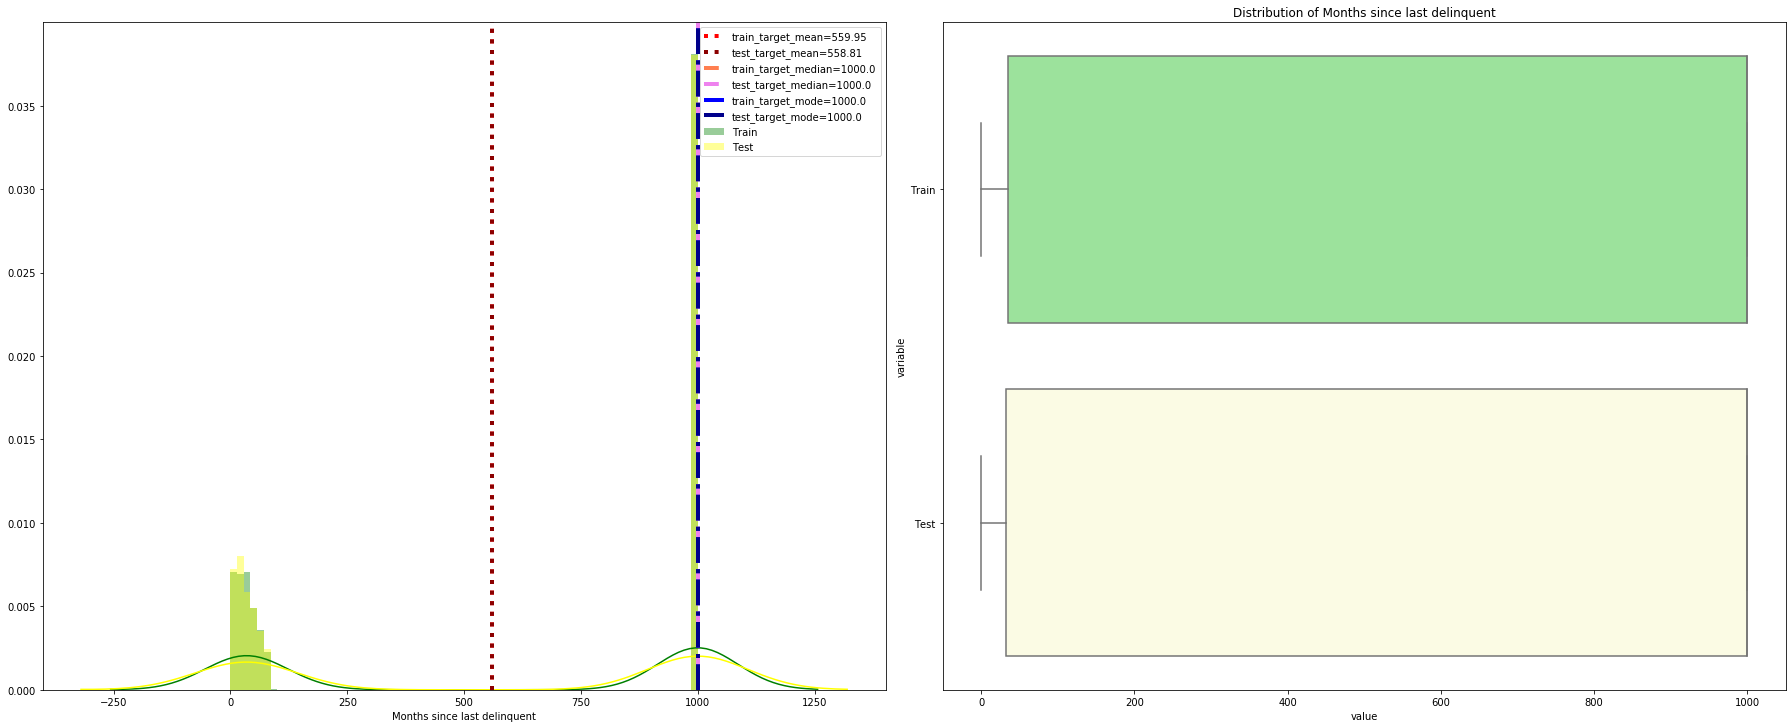

In [50]:
show_train_test_displot_and_boxplot(feature='Months since last delinquent', train=train_data, test=test_data, 
                        title='Distribution of Months since last delinquent', figsize=(25,10))

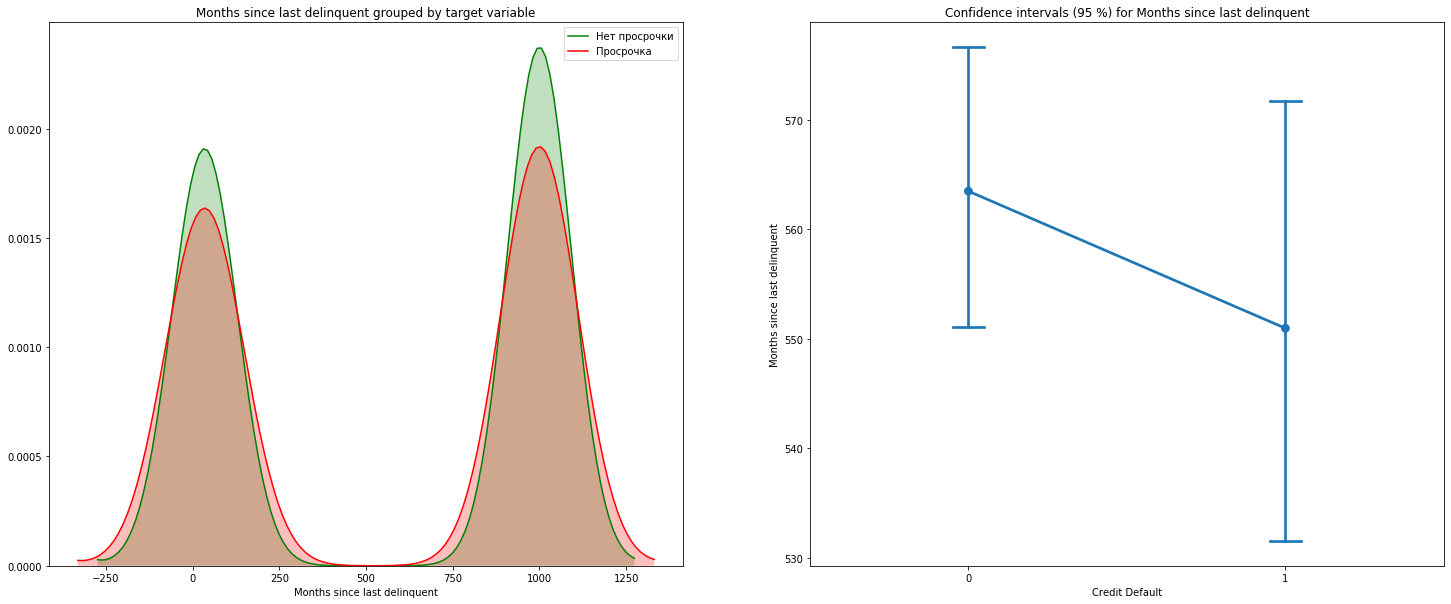

In [51]:
feature_grouped_by_target('Months since last delinquent', train_data, figsize=(25,10), condition=True)

In [52]:
# Потенциально бесполезный признак
bad_features.append('Months since last delinquent')

#### 2.3.8 Bankruptcies - банкротства

In [53]:
display(train_data['Bankruptcies'].value_counts(), test_data['Bankruptcies'].value_counts())

0.0    6660
1.0     800
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

0.0    2252
1.0     237
2.0       5
3.0       3
5.0       2
4.0       1
Name: Bankruptcies, dtype: int64

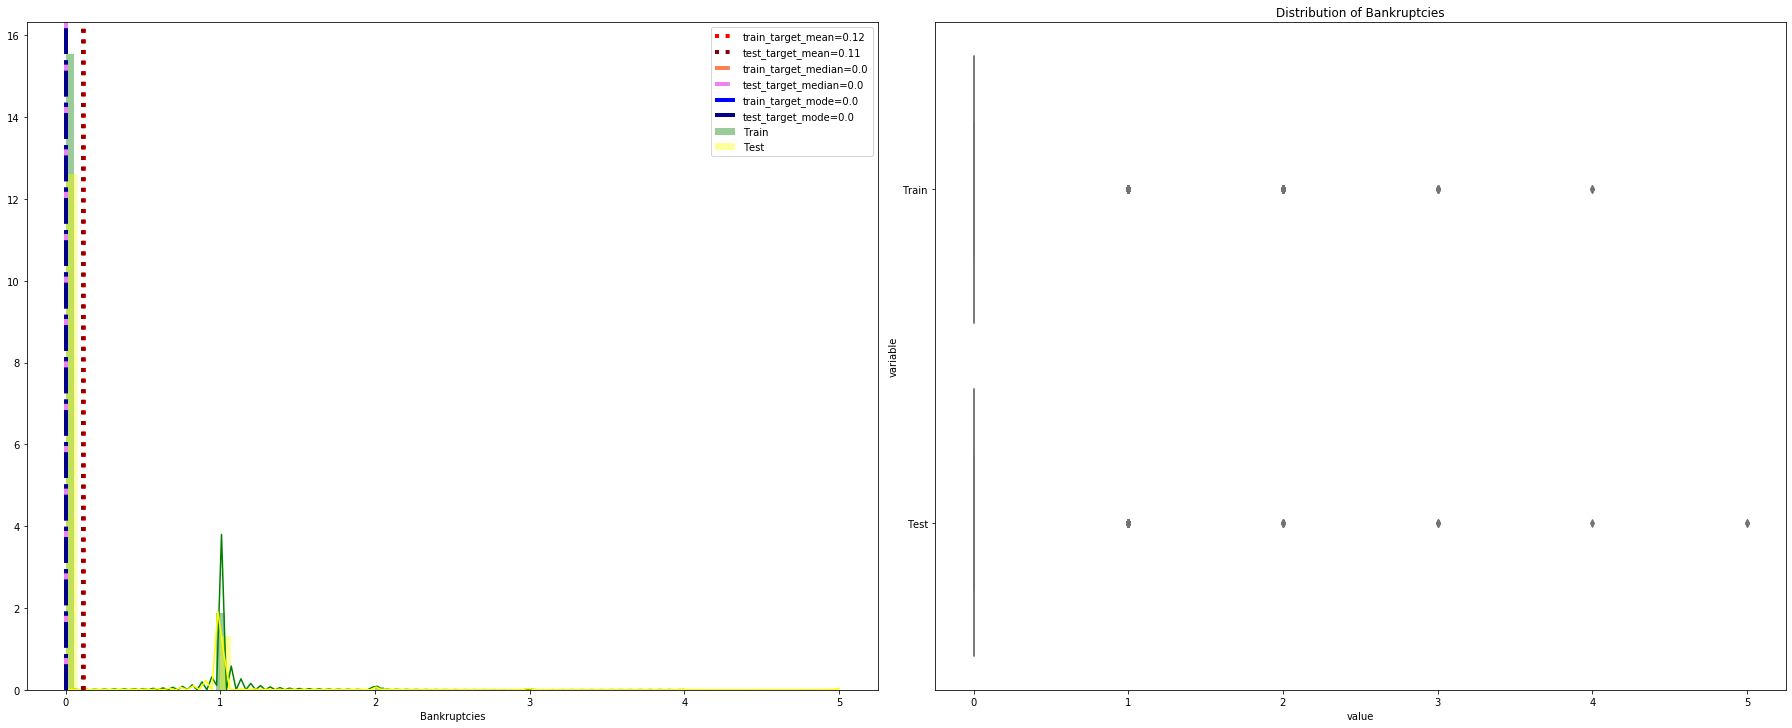

In [54]:
show_train_test_displot_and_boxplot(feature='Bankruptcies', train=train_data, test=test_data, 
                        title='Distribution of Bankruptcies', figsize=(25,10))

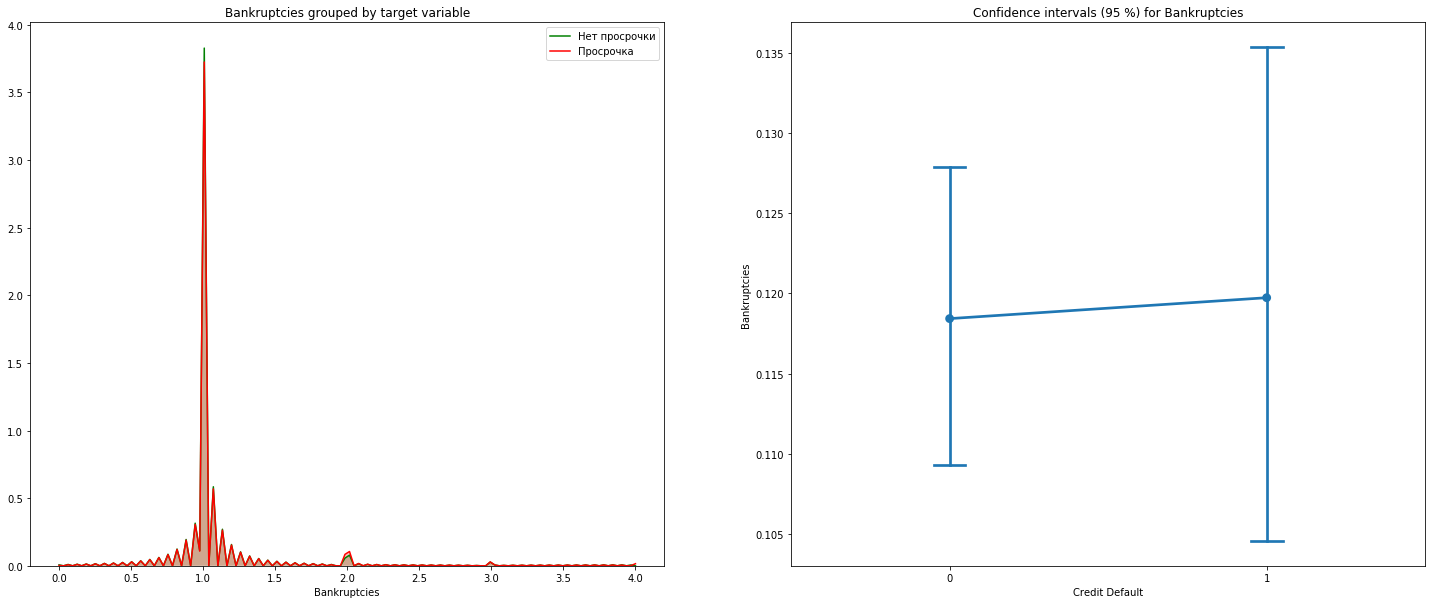

In [55]:
feature_grouped_by_target('Bankruptcies', train_data, figsize=(25,10), condition=True)

In [56]:
# Потенциально бесполезный признак
bad_features.append('Bankruptcies')

#### 2.3.9 Current Loan Amount - текущая сумма кредита

Значение 99999999 кажется выбросом, но в данных довольно много объектов(>10%) с таким значением. Не совсем понятно, как интерпретировать данное слишком большое значение, может что-то из серии "безлимитная кредитная карта".

In [57]:
train_data.loc[train_data['Current Loan Amount']==99999999, 'Credit Default'].value_counts()

0    870
Name: Credit Default, dtype: int64

In [58]:
train_data.loc[train_data['Current Loan Amount']==99999999, 'Current Loan Amount'] = train_data.loc[train_data['Current Loan Amount']<99999999, 'Current Loan Amount'].mean()
test_data.loc[test_data['Current Loan Amount']==99999999, 'Current Loan Amount'] = test_data.loc[test_data['Current Loan Amount']<99999999, 'Current Loan Amount'].mean()

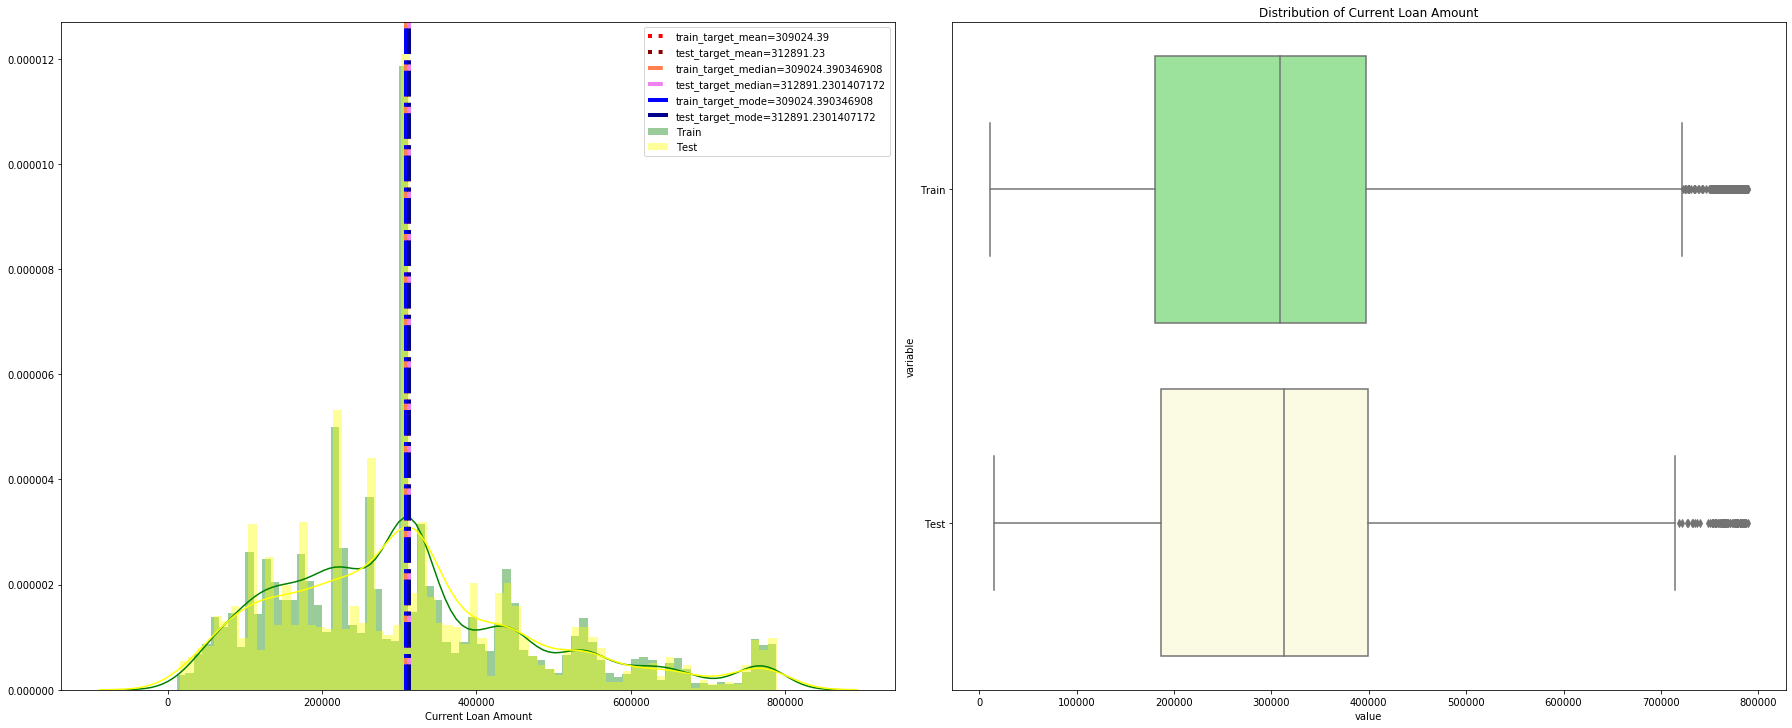

In [59]:
show_train_test_displot_and_boxplot(feature='Current Loan Amount', 
                                    train=train_data[train_data['Current Loan Amount']<99999999], 
                                    test=test_data[test_data['Current Loan Amount']<99999999], 
                        title='Distribution of Current Loan Amount', figsize=(25,10))

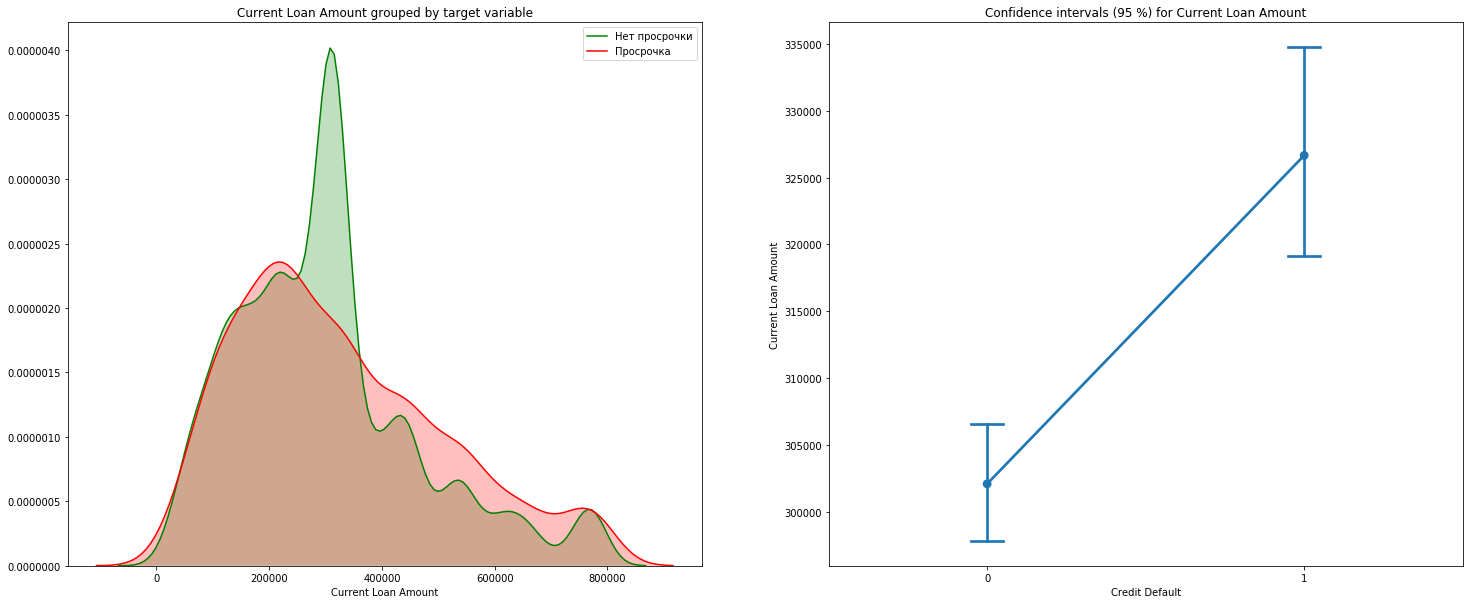

In [60]:
feature_grouped_by_target('Current Loan Amount', train_data, figsize=(25,10), condition=train_data['Current Loan Amount']<99999999)

#### 2.3.10 Current Credit Balance - текущий кредитный баланс

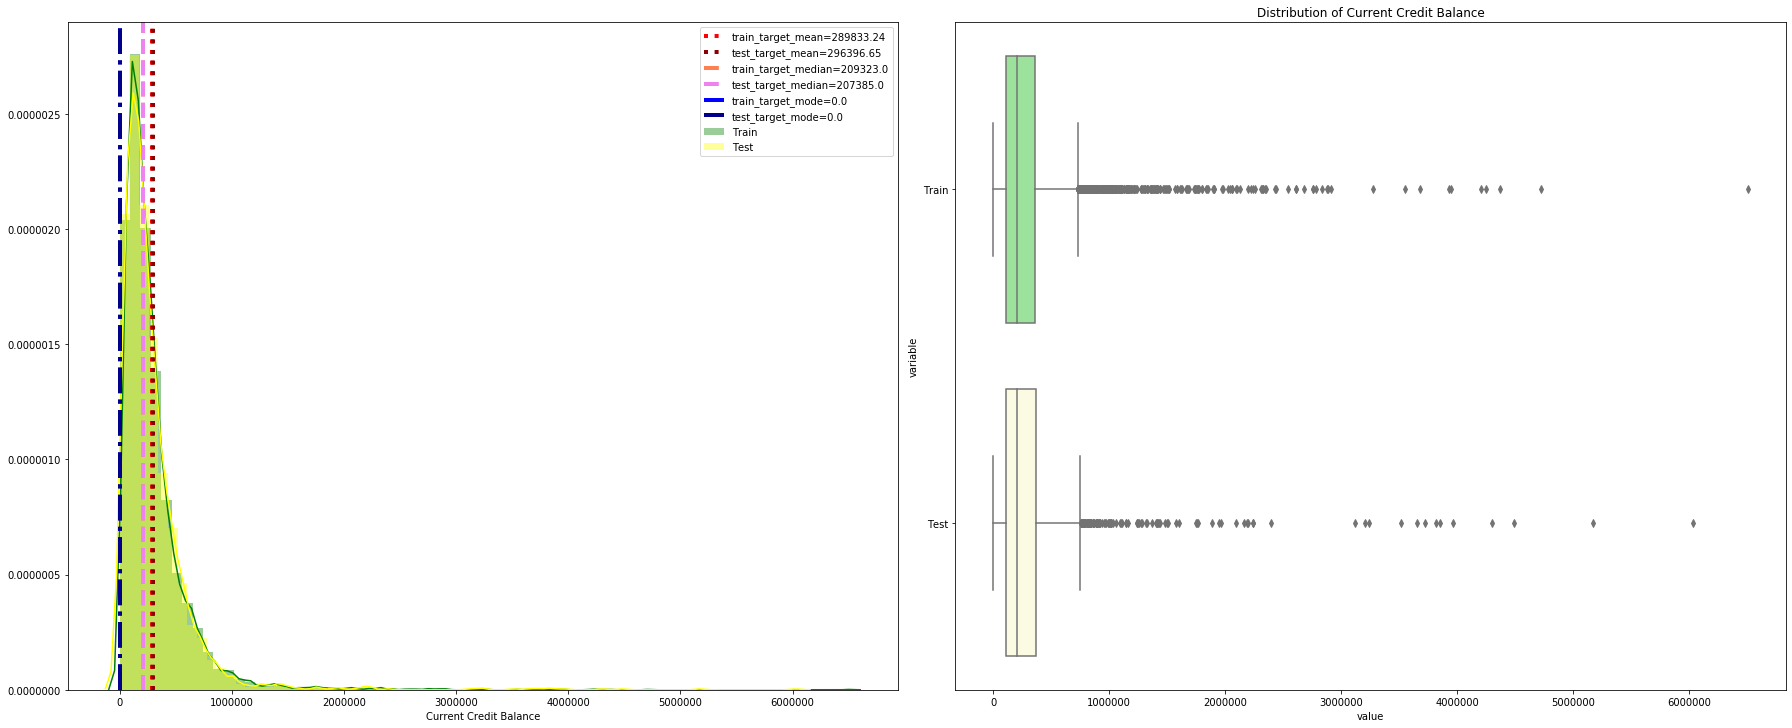

In [61]:
show_train_test_displot_and_boxplot(feature='Current Credit Balance', train=train_data, test=test_data, 
                        title='Distribution of Current Credit Balance', figsize=(25,10))

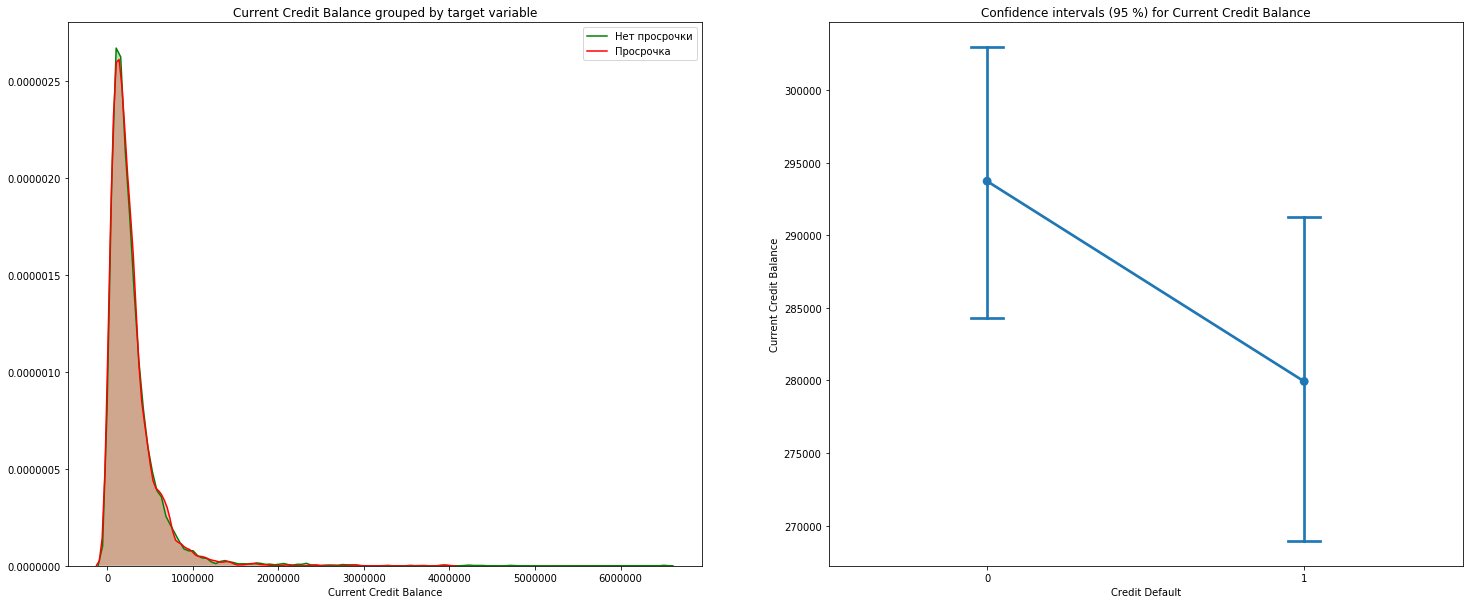

In [62]:
feature_grouped_by_target('Current Credit Balance', train_data, figsize=(25,10), condition=True)

In [63]:
# Потенциально бесполезный признак
#bad_features.append('Current Credit Balance')

#### 2.3.11 Monthly Debt - ежемесячный долг

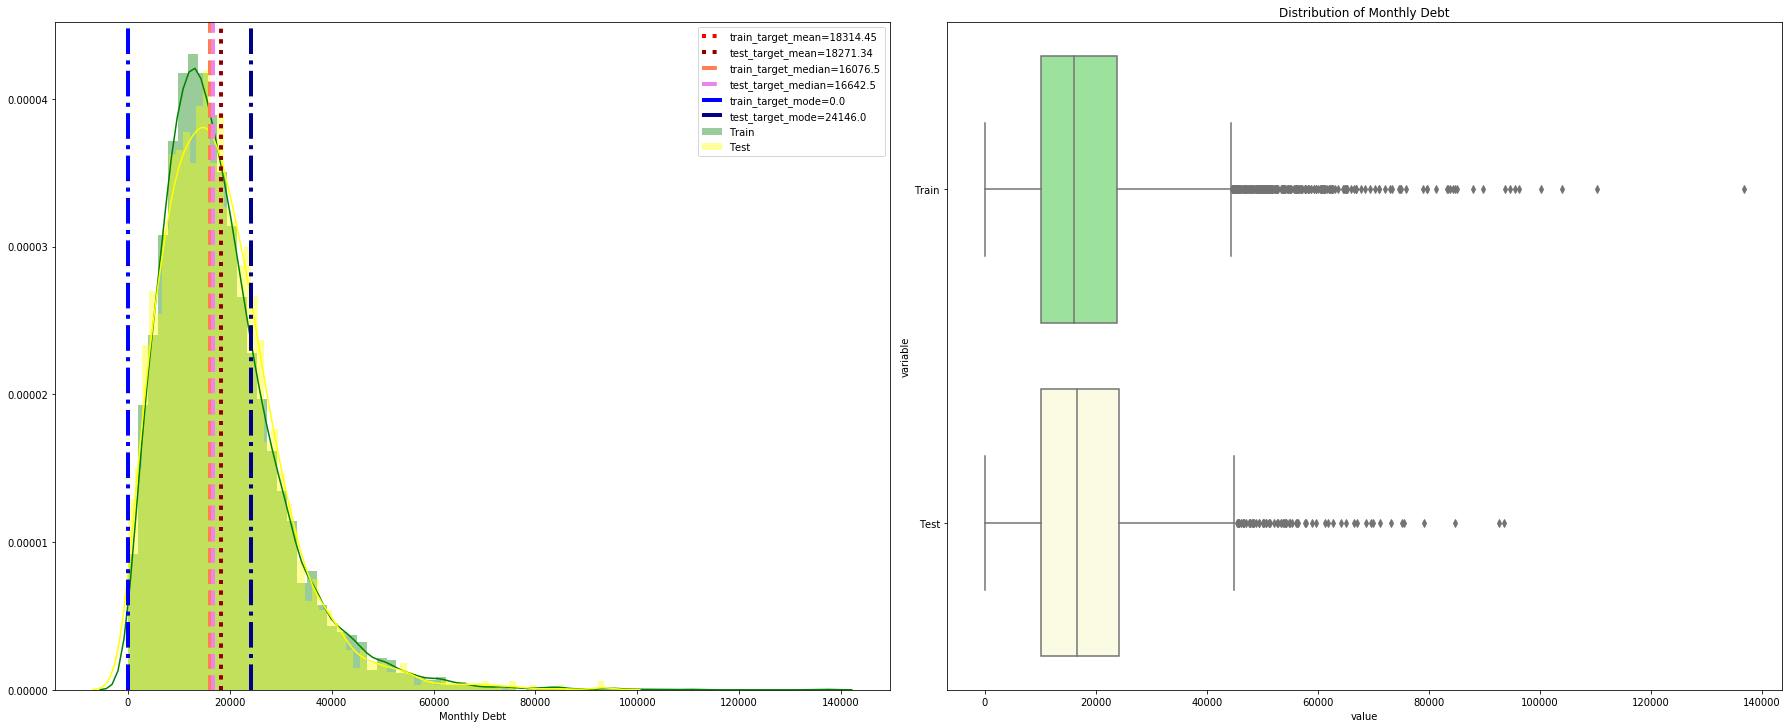

In [64]:
show_train_test_displot_and_boxplot(feature='Monthly Debt', train=train_data, test=test_data, 
                        title='Distribution of Monthly Debt', figsize=(25,10))

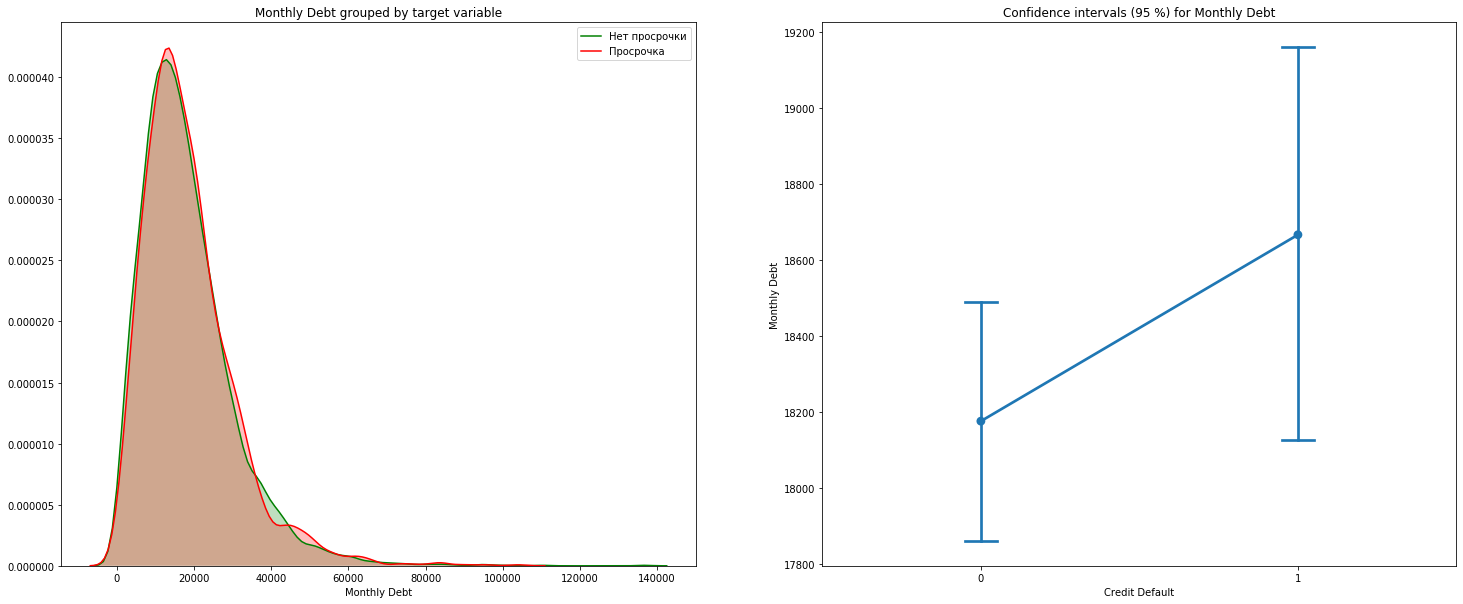

In [65]:
feature_grouped_by_target('Monthly Debt', train_data, figsize=(25,10), condition=True)

In [66]:
# Потенциально бесполезный признак
bad_features.append('Monthly Debt')

#### 2.3.12 Credit Score - кредитный рейтинг

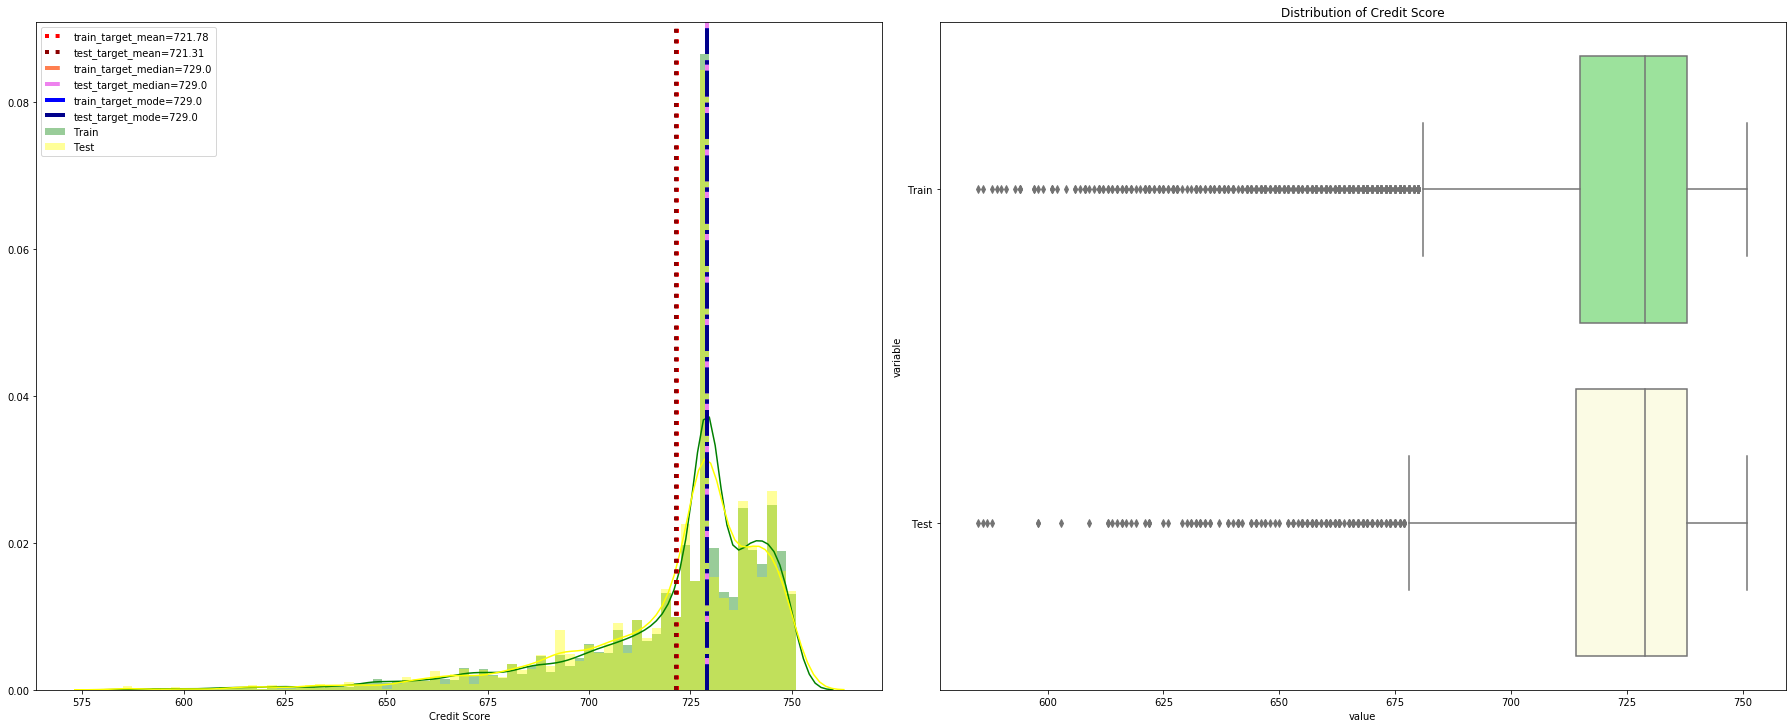

In [67]:
show_train_test_displot_and_boxplot(feature='Credit Score', train=train_data, test=test_data, 
                        title='Distribution of Credit Score', figsize=(25,10))

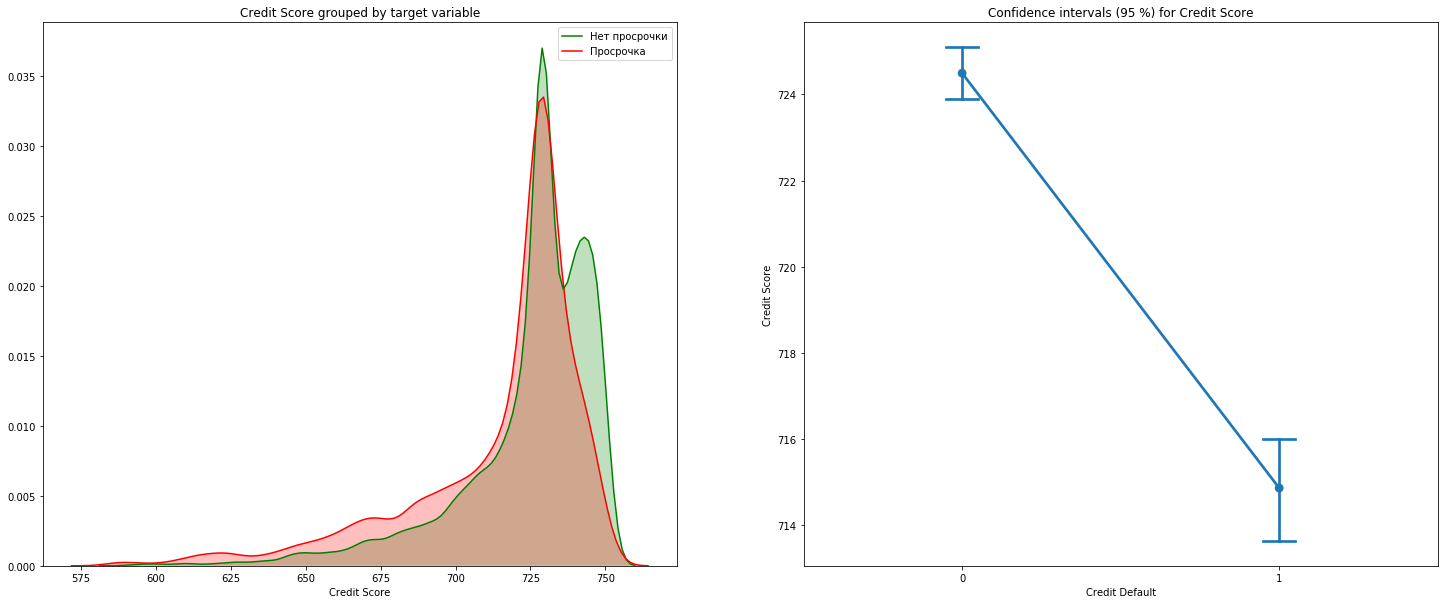

In [68]:
feature_grouped_by_target('Credit Score', train_data, figsize=(25,10), condition=True)

#### 2.3.13 Home Ownership - домовладение

Объединим значения "Home Mortgage" и "Have Mortgage".

In [69]:
display(train_data['Home Ownership'].value_counts(), test_data['Home Ownership'].value_counts())

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64

In [70]:
map_Home_Ownership = {
    'Have Mortgage': 'Mortgage',
    'Home Mortgage': 'Mortgage',
    'Own Home': 'Home',
    'Rent': 'Rent'
}
train_data['Home Ownership'] = train_data['Home Ownership'].map(map_Home_Ownership)
test_data['Home Ownership'] = test_data['Home Ownership'].map(map_Home_Ownership)

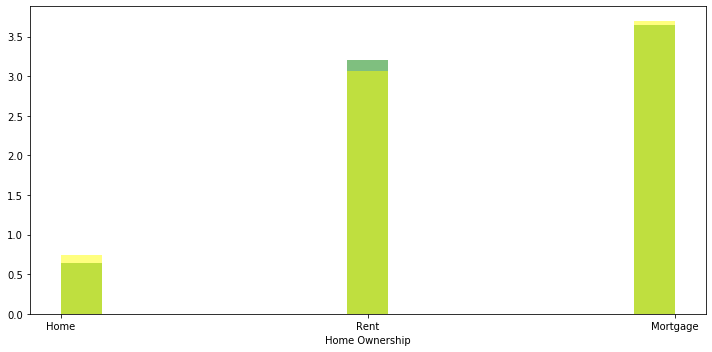

In [71]:
fig = plt.figure(figsize=(10,5))

plt.hist(train_data['Home Ownership'], bins=15, density=True, label='Train', alpha=0.5, color='green')
plt.hist(test_data['Home Ownership'], bins=15, density=True, label='Test', alpha=0.5, color='yellow')
plt.xlabel('Home Ownership')
plt.tight_layout()
plt.show()

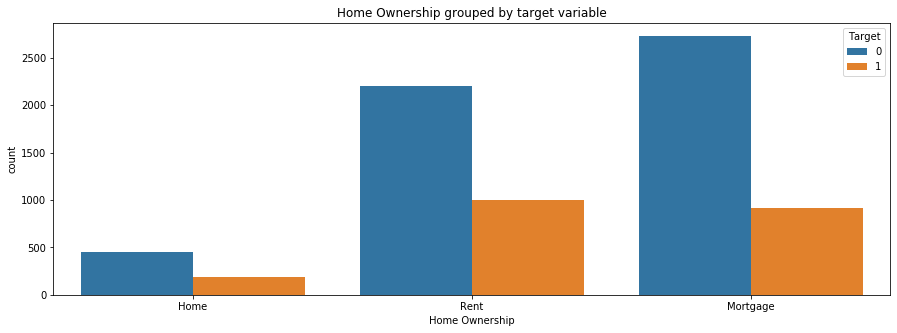

In [72]:
plt.figure(figsize=(15, 5))

sns.countplot(x='Home Ownership', hue=target_feature, data=train_data)
plt.title('Home Ownership grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

#### 2.3.14 Years in current job - количество лет на текущем месте работы

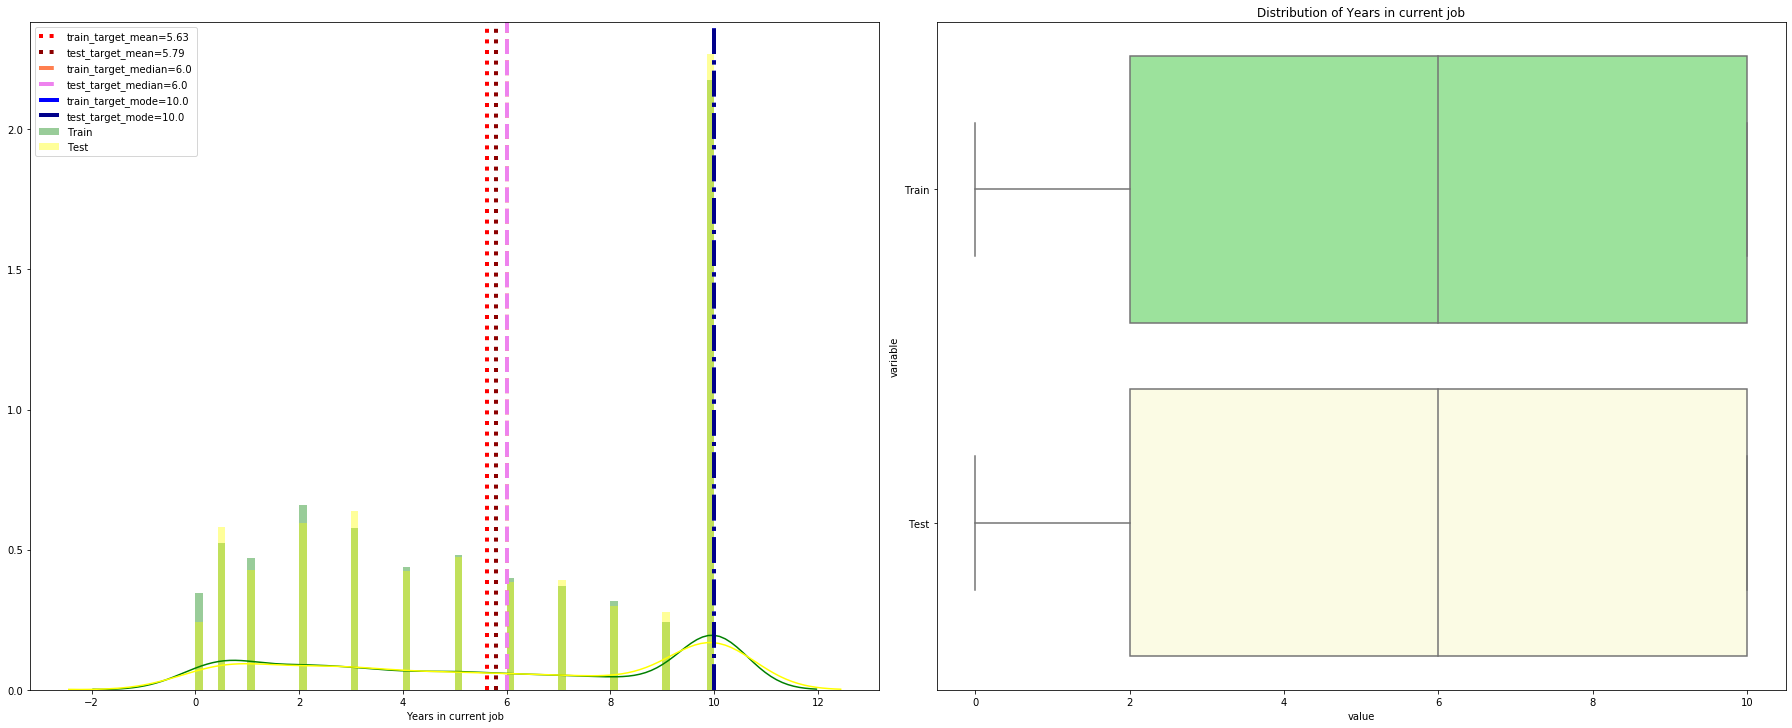

In [73]:
show_train_test_displot_and_boxplot(feature='Years in current job', train=train_data, test=test_data, 
                        title='Distribution of Years in current job', figsize=(25,10))

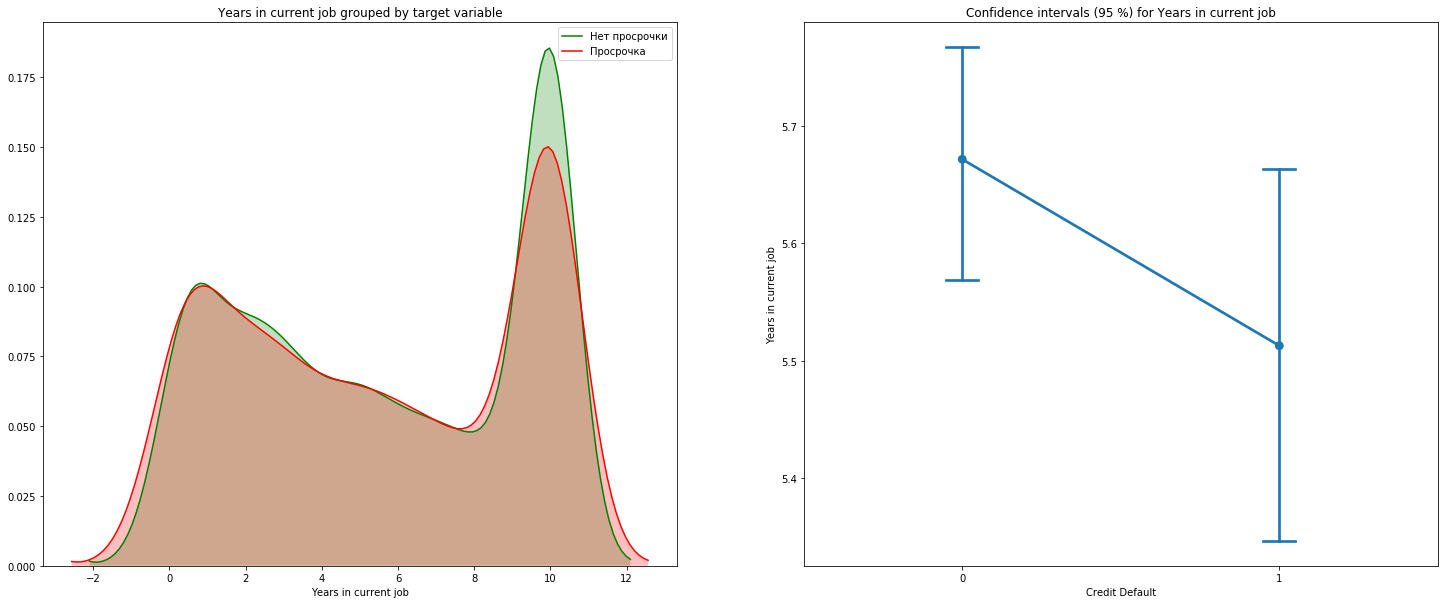

In [74]:
feature_grouped_by_target('Years in current job', train_data, figsize=(25,10), condition=True)

In [75]:
# Потенциально бесполезный признак
bad_features.append('Years in current job')

#### 2.3.15 Term - срок кредита

In [76]:
display(train_data['Term'].value_counts(), test_data['Term'].value_counts())

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

Short Term    1861
Long Term      639
Name: Term, dtype: int64

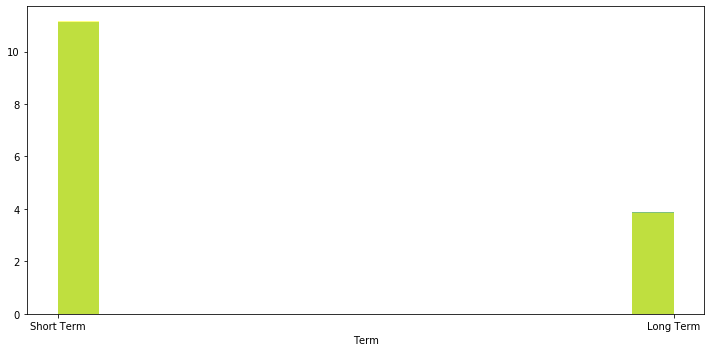

In [77]:
fig = plt.figure(figsize=(10,5))

plt.hist(train_data['Term'], bins=15, density=True, label='Train', alpha=0.5, color='green')
plt.hist(test_data['Term'], bins=15, density=True, label='Test', alpha=0.5, color='yellow')
plt.xlabel('Term')
plt.tight_layout()
plt.show()

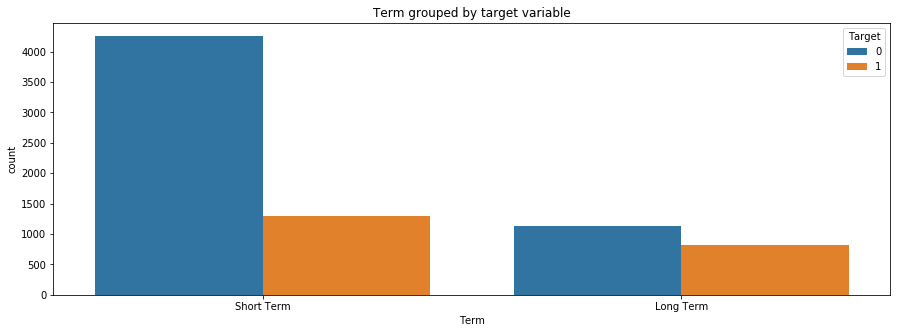

In [78]:
plt.figure(figsize=(15, 5))

sns.countplot(x='Term', hue=target_feature, data=train_data)
plt.title('Term grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

#### 2.3.16 Purpose - цель кредита

In [79]:
display(train_data['Purpose'].value_counts(), test_data['Purpose'].value_counts())

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
educational expenses       3
vacation                   3
wedding                    2
moving                     1
Name: Purpose, dtype: int64

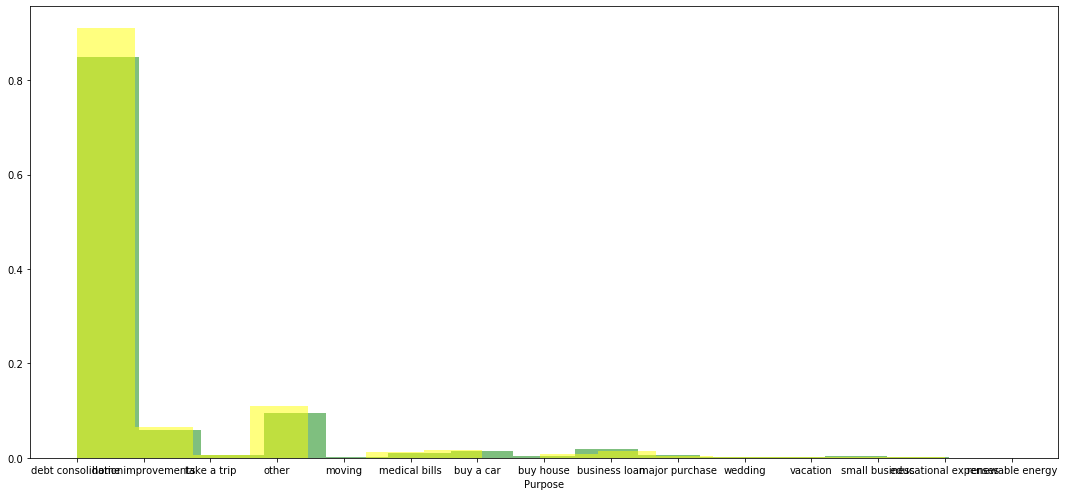

In [80]:
fig = plt.figure(figsize=(15,7))

plt.hist(train_data['Purpose'], bins=15, density=True, label='Train', alpha=0.5, color='green')
plt.hist(test_data['Purpose'], bins=15, density=True, label='Test', alpha=0.5, color='yellow')
plt.xlabel('Purpose')
plt.tight_layout()
plt.show()

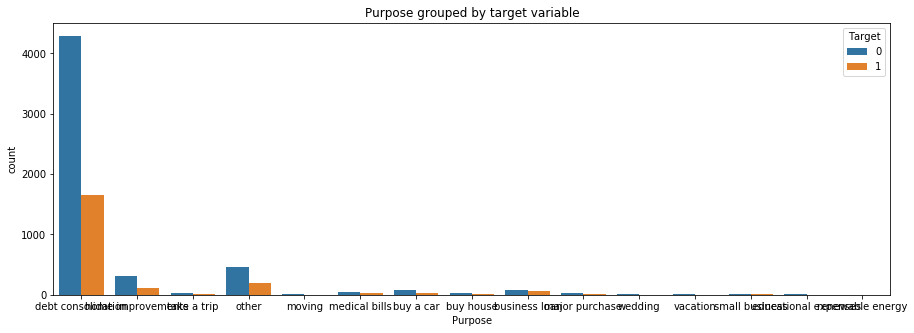

In [81]:
plt.figure(figsize=(15, 5))

sns.countplot(x='Purpose', hue=target_feature, data=train_data)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

### 2.4 Корреляция с целевой переменной

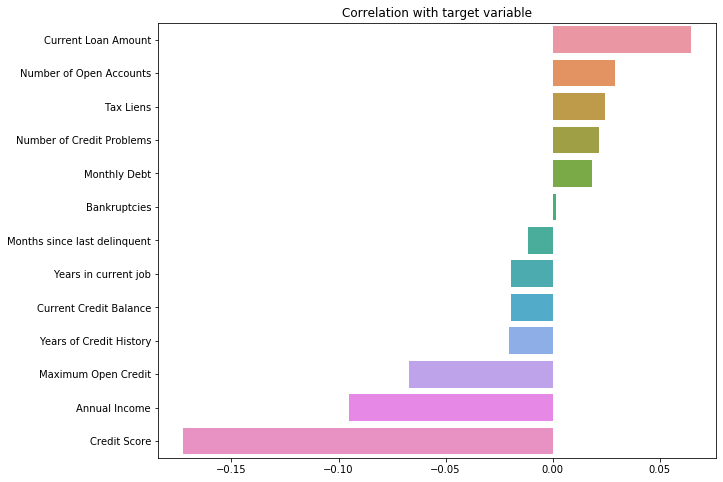

In [82]:
corr_with_target = train_data[base_features + [target_feature]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### 2.5 Добавление новых признаков

In [83]:
# Monthly Debt / Annual Income
tr_temp = train_data.copy()
tr_temp.loc[tr_temp['Annual Income']==0,'Annual Income'] = 1e-5
tr_temp['MA'] = tr_temp['Monthly Debt'] / tr_temp['Annual Income']

ts_temp = test_data.copy()
ts_temp.loc[ts_temp['Annual Income']==0,'Annual Income'] = 1e-5
ts_temp['MA'] = ts_temp['Monthly Debt'] / ts_temp['Annual Income']

train_data['MA'] = tr_temp['MA']
test_data['MA'] = ts_temp['MA']

# Maximum Open Credit / Current Loan Amount
tr_temp.loc[tr_temp['Current Loan Amount']==0,'Current Loan Amount'] = 1e-5
tr_temp['MC'] = tr_temp['Maximum Open Credit'] / tr_temp['Current Loan Amount']

ts_temp.loc[ts_temp['Current Loan Amount']==0,'Current Loan Amount'] = 1e-5
ts_temp['MC'] = ts_temp['Maximum Open Credit'] / ts_temp['Current Loan Amount']

train_data['MC'] = tr_temp['MC']
test_data['MC'] = ts_temp['MC']

# Current Loan Amount / Current Credit Balance
tr_temp.loc[tr_temp['Current Credit Balance']==0,'Current Credit Balance'] = 1e-5
tr_temp['CC'] = tr_temp['Current Loan Amount'] / tr_temp['Current Credit Balance']

ts_temp.loc[ts_temp['Current Credit Balance']==0,'Current Credit Balance'] = 1e-5
ts_temp['CC'] = ts_temp['Current Loan Amount'] / ts_temp['Current Credit Balance']

train_data['CC'] = tr_temp['CC']
test_data['CC'] = ts_temp['CC']

# Annual Income / Current Loan Amount
tr_temp['AC'] = tr_temp['Annual Income'] / tr_temp['Current Loan Amount']
ts_temp['AC'] = ts_temp['Annual Income'] / ts_temp['Current Loan Amount']

train_data['AC'] = tr_temp['AC']
test_data['AC'] = ts_temp['AC']

### 2.6 Поиск взаимосвязей между признаками

In [84]:
for colname in ['Home Ownership', 'Purpose', 'Term', 'Null Annual Income and Credit Score']:
    train_data[colname] = train_data[colname].astype(str)
    test_data[colname] = test_data[colname].astype(str)

In [85]:
target_feature = 'Credit Default'
base_features = train_data.drop(['Credit Default'], axis=1).columns.tolist()
num_features = train_data.select_dtypes(exclude=['object']).drop(['Credit Default'], axis=1).columns
cat_features = train_data.select_dtypes(include=['object']).columns

display(len(base_features), base_features, len(num_features), num_features, len(cat_features), cat_features)

21

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Null Annual Income and Credit Score',
 'MA',
 'MC',
 'CC',
 'AC']

17

Index(['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount',
       'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'MA', 'MC',
       'CC', 'AC'],
      dtype='object')

4

Index(['Home Ownership', 'Purpose', 'Term',
       'Null Annual Income and Credit Score'],
      dtype='object')

In [86]:
corr_features = base_features + [target_feature]
corr = train_data[corr_features].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,MA,MC,CC,AC,Credit Default
Annual Income,1,0.12,0.056,0.17,0.17,0.28,-0.027,-0.065,-0.07,0.37,0.35,0.52,0.016,-0.18,0.057,0.025,0.27,-0.095
Years in current job,0.12,1,0.0032,0.064,0.15,0.091,0.013,-0.045,0.017,0.15,0.11,0.15,-0.012,0.055,0.013,0.00026,-0.02,-0.019
Tax Liens,0.056,0.0032,1,-0.0054,0.0091,-0.0095,0.54,-0.052,0.056,0.03,-0.01,0.027,-0.021,-0.0014,-0.013,-0.0075,-0.0039,0.024
Number of Open Accounts,0.17,0.064,-0.0054,1,0.14,0.3,-0.018,-0.063,-0.021,0.2,0.27,0.41,-0.029,0.32,0.11,-0.05,-0.051,0.029
Years of Credit History,0.17,0.15,0.0091,0.14,1,0.21,0.074,-0.14,0.085,0.14,0.22,0.19,0.059,0.073,0.092,-0.00084,0.029,-0.021
Maximum Open Credit,0.28,0.091,-0.0095,0.3,0.21,1,-0.1,0.081,-0.11,0.26,0.75,0.33,0.098,0.13,0.52,-0.056,0.011,-0.067
Number of Credit Problems,-0.027,0.013,0.54,-0.018,0.074,-0.1,1,-0.043,0.76,-0.068,-0.13,-0.048,-0.065,-0.021,-0.033,-0.016,0.015,0.022
Months since last delinquent,-0.065,-0.045,-0.052,-0.063,-0.14,0.081,-0.043,1,0.0025,0.0061,0.093,-0.03,0.084,0.0087,0.042,-0.014,-0.029,-0.012
Bankruptcies,-0.07,0.017,0.056,-0.021,0.085,-0.11,0.76,0.0025,1,-0.093,-0.14,-0.084,-0.049,-0.032,-0.045,-0.016,0.0082,0.0017
Current Loan Amount,0.37,0.15,0.03,0.2,0.14,0.26,-0.068,0.0061,-0.093,1,0.34,0.41,-0.18,0.14,-0.17,0.036,-0.46,0.064


Признаки "Current Credit Balance" и "Maximum Open Credit", а также "Bankruptcies" и "Number of Credit Problems" высоко коррелируют между собой, но недостаточно, чтобы удалить один из них.

Посчитаем WOE&IV для признаков

In [87]:
clf = WOE()
clf.fit(train_data.drop(['Credit Default'],axis=1), train_data['Credit Default'])

WOE(mono_custom_binning={'AC': array([  0.70128445,   3.32119492,   5.46181776, 103.59851252]),
                         'Annual Income': array([  164597.        ,  1052644.33333333,  1312165.33333333,
       10149344.        ]),
                         'Bankruptcies': array([0., 1., 2., 3., 4.]),
                         'CC': array([2.30267727e-02, 9.81173555e-01, 1.71574699e+00, 7.60452000e+10]),
                         'Credit Score': array([585., 723., 733., 751.]),
                         'Current Credit Balance': array([      0.        ,...
              'Years in current job': {Interval(-0.001, 3.0, closed='right'): 0.04002121200752768,
                                       Interval(3.0, 9.0, closed='right'): -0.01974668763998204,
                                       Interval(9.0, 10.0, closed='right'): -0.027721043987071807},
              'Years of Credit History': {Interval(3.999, 14.8, closed='right'): 0.07572985491909566,
                                          Int

In [88]:
clf.iv_df

,Variable_Name,Information_Value
18,Term,0.152956
4,Credit Score,0.144635
6,Current Loan Amount,0.091742
0,AC,0.073932
1,Annual Income,0.054730
8,MA,0.053862
9,MC,0.037130
7,Home Ownership,0.021572
13,Null Annual Income and Credit Score,0.020709
16,Purpose,0.016824


In [89]:
woe_num_features = ['Credit Score', 'Annual Income', 'MA', 'CC', 'Current Loan Amount', 'MC', 'Maximum Open Credit']
woe_cat_features = ['Home Ownership', 'Purpose', 'Term', 'Null Annual Income and Credit Score']

train_num = train_data[woe_num_features]
test_num = test_data[woe_num_features]

train_cat = train_data[woe_cat_features]
test_cat = test_data[woe_cat_features]

In [90]:
good_base_features = list(set(base_features)) #- set(bad_features))
good_base_features

['Credit Score',
 'Maximum Open Credit',
 'Years in current job',
 'MA',
 'AC',
 'Years of Credit History',
 'Tax Liens',
 'Number of Credit Problems',
 'Term',
 'MC',
 'Current Credit Balance',
 'Months since last delinquent',
 'Number of Open Accounts',
 'Monthly Debt',
 'CC',
 'Bankruptcies',
 'Current Loan Amount',
 'Home Ownership',
 'Null Annual Income and Credit Score',
 'Purpose',
 'Annual Income']

### 2.7 Анализ целевого признака

##### **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [91]:
train_data['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Данные несбалансированные.

In [92]:
disbalance = train_data['Credit Default'].value_counts()[0] / train_data['Credit Default'].value_counts()[1]
disbalance

2.549455750118315

### 2.8 Отбор признаков

In [93]:
train = train_data[good_base_features]
test = test_data[good_base_features]
target = train_data[target_feature]
cat_features

Index(['Home Ownership', 'Purpose', 'Term',
       'Null Annual Income and Credit Score'],
      dtype='object')

### 2.9 Балансировка данных

In [94]:
display(target.value_counts(), disbalance)

0    5387
1    2113
Name: Credit Default, dtype: int64

2.549455750118315

In [95]:
# Oversampling
oversample = over_sampling.RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(train, target)
print(f'До oversampling:\n{target.value_counts()}')
print(f'\nПосле oversampling:\n{y_over.value_counts()}')

До oversampling:
0    5387
1    2113
Name: Credit Default, dtype: int64

После oversampling:
1    5387
0    5387
Name: Credit Default, dtype: int64


In [96]:
# Undersampling
undersample = under_sampling.RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(train, target)
print(f'До undersampling:\n{target.value_counts()}')
print(f'\nПосле undersampling:\n{y_under.value_counts()}')

До undersampling:
0    5387
1    2113
Name: Credit Default, dtype: int64

После undersampling:
1    2113
0    2113
Name: Credit Default, dtype: int64


### 2.10 Обучающая и валидационная выборки

Разобьем тренировочные данные на обучающую и валидационную выборки. <br>

In [97]:
X_train, X_test, y_train, y_test = train_test_split(train, target, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=9,
                                                    stratify=target)

X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_over, y_over, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=9,
                                                    stratify=y_over)

X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_under, y_under, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=9,
                                                    stratify=y_under)

## 3 Построение модели и оценка датасетов

In [98]:
# Максимальное количество уникальных значений категориальных переменных
sorted([X_train[cat_features][col].nunique() for col in cat_features])[-1]

15

In [99]:
train_pool = catb.Pool(
    X_train,
    y_train,
    cat_features=cat_features
)

test_pool = catb.Pool(
    X_test,
    y_test,
    cat_features=cat_features
) 

params_model = {
    'eval_metric': 'F1',
    'class_weights':[1, disbalance],
    'silent': True,
    'one_hot_max_size': 15,
    'early_stopping_rounds': 20,
    'boosting_type': 'Ordered',
    'allow_writing_files': False
}

cb1 = catb.CatBoostClassifier(**params_model, depth=5, random_state=9)
cb1.fit(train_pool, eval_set=test_pool)
y_train_pred = cb1.predict(X_train)
y_test_pred = cb1.predict(X_test)

f1_t = f1_score(y_train, y_train_pred, average=None)[1]
f1_ts = f1_score(y_test, y_test_pred, average=None)[1]
print(f1_t, f1_ts, f1_t-f1_ts)

0.5373364126250962 0.5107692307692308 0.026567181855865485


In [100]:
train_pool = catb.Pool(
    X_train_o,
    y_train_o,
    cat_features=cat_features
)

test_pool = catb.Pool(
    X_test_o,
    y_test_o,
    cat_features=cat_features
) 

params_model = {
    'eval_metric': 'F1',
    'class_weights':[1, 1],
    'silent': True,
    'one_hot_max_size': 15,
    'early_stopping_rounds': 20,
    'boosting_type': 'Ordered',
    'allow_writing_files': False
}

cb2 = catb.CatBoostClassifier(**params_model, depth=5, random_state=9)
cb2.fit(train_pool, eval_set=test_pool)
y_train_pred = cb2.predict(X_train_o)
y_test_pred = cb2.predict(X_test_o)

f1_t = f1_score(y_train_o, y_train_pred, average=None)[1]
f1_ts = f1_score(y_test_o, y_test_pred, average=None)[1]
print(f1_t, f1_ts, f1_t-f1_ts)

0.6933830382106245 0.6957364341085271 -0.0023533958979026215


In [101]:
train_pool = catb.Pool(
    X_train_u,
    y_train_u,
    cat_features=cat_features
)

test_pool = catb.Pool(
    X_test_u,
    y_test_u,
    cat_features=cat_features
) 

params_model = {
    'eval_metric': 'F1',
    'class_weights':[1, 1],
    'silent': True,
    'one_hot_max_size': 15,
    'early_stopping_rounds': 20,
    'boosting_type': 'Ordered',
    'allow_writing_files': False
}

cb3 = catb.CatBoostClassifier(**params_model, depth=5, random_state=9)
cb3.fit(train_pool, eval_set=test_pool)
y_train_pred = cb3.predict(X_train_u)
y_test_pred = cb3.predict(X_test_u)

f1_t = f1_score(y_train_u, y_train_pred, average=None)[1]
f1_ts = f1_score(y_test_u, y_test_pred, average=None)[1]
print(f1_t, f1_ts, f1_t-f1_ts)

0.6775207083690373 0.6622604097818903 0.015260298587147059


Лучший результат показали датасеты с балансировкой, но они переобучаются, поэтому будем использовать датасет без балансировки и балансировать его средствами модели.

In [102]:
train_pool = catb.Pool(
    X_train,
    y_train,
    cat_features=cat_features
)

test_pool = catb.Pool(
    X_test,
    y_test,
    cat_features=cat_features
) 

params_model = {
    'eval_metric': 'F1',
    #'auto_class_weights': 'Balanced',
    'class_weights':[1, disbalance],
    'silent': True,
    'one_hot_max_size': 15,
    'early_stopping_rounds': 20,
    'boosting_type': 'Ordered',
    'allow_writing_files': False
}

In [103]:
%%time

cbr_model = catb.CatBoostClassifier(**params_model)

params_grid = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.1, 0.3, 0.5, 0.8],
    'iterations': [50, 100, 200, 500],
    'l2_leaf_reg': [0.01, 0.05, 0.1, 0.5, 1, 2, 2.5, 3, 3.5, 4],
    'bagging_temperature': [1, 1.5, 2]
}

gs = cbr_model.randomized_search(
    params_grid,
    train_pool,
    n_iter=20,
    shuffle=True,
    stratified=True,
    partition_random_seed=9,
    cv=3
)

gs

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6133092414
bestIteration = 16

0:	loss: 0.6133092	best: 0.6133092 (0)	total: 1.95s	remaining: 37.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6120021225
bestIteration = 3

1:	loss: 0.6120021	best: 0.6133092 (0)	total: 3.17s	remaining: 28.5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.5785165637
bestIteration = 0

2:	loss: 0.5785166	best: 0.6133092 (0)	total: 6.81s	remaining: 38.6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6376210249
bestIteration = 50

3:	loss: 0.6376210	best: 0.6376210 (3)	total: 7.34s	remaining: 29.4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6570369778
bestIteration = 15

4:	loss: 0.6570370	best: 0.6570370 (4)	total: 7.85s	remaining: 23.6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.5510346525
bestIteration = 3

5:	loss: 0.5510347	best: 0.6570370 (4)	total: 8.19s	remaining: 1

{'params': {'depth': 6,
  'iterations': 50,
  'bagging_temperature': 1.5,
  'learning_rate': 0.5,
  'l2_leaf_reg': 0.01},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31],
              'test-F1-mean': [0.5401403459024645,
               0.5857057974387492,
               0.6244080731494194,
               0.6319881019170556,
               0.65147540532015,
               0.6455398839022318,
        

Лучшие гиперпараметры: {'depth': 6,
  'iterations': 50,
  'bagging_temperature': 1.5,
  'learning_rate': 0.5,
  'l2_leaf_reg': 0.01}

In [104]:
%%time

cb = catb.CatBoostClassifier(
    **params_model,
    depth=6,
    iterations=50,
    learning_rate=0.5,
    l2_leaf_reg=0.01,
    bagging_temperature=1.5
)

cb.fit(train_pool, eval_set=test_pool)

CPU times: user 1.06 s, sys: 42.5 ms, total: 1.1 s
Wall time: 372 ms


In [105]:
evaluate_preds(cb, y_train, y_test, train_pool, test_pool)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.41      0.56      3771
           1       0.36      0.85      0.51      1479

    accuracy                           0.53      5250
   macro avg       0.62      0.63      0.53      5250
weighted avg       0.73      0.53      0.54      5250

TEST

              precision    recall  f1-score   support

           0       0.86      0.42      0.56      1616
           1       0.36      0.82      0.50       634

    accuracy                           0.53      2250
   macro avg       0.61      0.62      0.53      2250
weighted avg       0.72      0.53      0.55      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               679  937
1               113  521


In [106]:
features = good_base_features
feature_importances = pd.DataFrame(
    zip(features, cb.get_feature_importance()),
    columns=['feature_name', 'importance']
)

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head(20)

,feature_name,importance
16,Current Loan Amount,59.321789
0,Credit Score,19.874993
8,Term,13.729943
4,AC,7.073276
12,Number of Open Accounts,0.000000
19,Purpose,0.000000
18,Null Annual Income and Credit Score,0.000000
17,Home Ownership,0.000000
15,Bankruptcies,0.000000
14,CC,0.000000


In [107]:
train_pool = catb.Pool(
    train,
    target,
    cat_features=cat_features
)

final_cb = catb.CatBoostClassifier(
    **params_model,
    depth=6,
    iterations=50,
    learning_rate=0.5,
    l2_leaf_reg=0.01,
    bagging_temperature=1.5
)

final_cb.fit(train_pool, eval_set=test_pool)

test_cb = test.copy()
y_test_pred = final_cb.predict(test_cb)

preds_cb = pd.DataFrame()
preds_cb = pd.DataFrame({'Id': np.arange(0,y_test_pred.shape[0]), 'Credit Default': y_test_pred})
preds_cb.to_csv('./ASmelova_predictions.csv', index=False, encoding='utf-8', sep=',')
preds_cb.head(10)

,Id,Credit Default
0,0,0
1,1,0
2,2,0
3,3,0
4,4,1
5,5,1
6,6,1
7,7,1
8,8,0
9,9,0
